In [7]:
from matplotlib import pyplot as plt
from torch import optim
from torch import nn
import pandas as pd

%config InlineBackend.figure_format='retina'

dataset = 'GD'
y = pd.read_csv(f"../data/{dataset}.csv")
y = y.iloc[:, -1].to_numpy()
y = (y - y.mean()) / y.std()
y

# data
num_samples = int(1e4)

from models.FITS_padding import FITS
# from models.FITS import FITS
# from models.deep_FITS_after_upscaler import FITS
from argparse import Namespace

n_epochs = 300
batch_size = 1
seq_len = 720
base_freq = 96
cut_off_harmonic = 10
cutoff_freq = int((seq_len / base_freq) * cut_off_harmonic)

args = Namespace(
    dominance_freq=cutoff_freq,
    seq_len=seq_len,
    pred_len=120,
    channels=1,
    individual=False,
    debug=True,
    num_hidden=64,
    num_layers=3,
    scalar=0.55,
)

print("dominance frequency:", args.dominance_freq)
model = FITS(args)

print(model)
print(f"Parameters {sum(p.numel() for p in model.parameters())}")

model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=170, bias=True)
)
Parameters 12920


In [8]:
import numpy as np
import torch
from torch import nn
np.random.seed(42)

early_stopping = False

def train(model, model_optim, n_channels, y, num_samples, epochs, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    min_delta = 0.000001  # minimum change to qualify as an improvement
    criterion = nn.MSELoss()
    best_epoch = 0

    for epoch in range(epochs):  # train for specified epochs
        order = np.random.permutation(
            int(num_samples * 0.8)
        )  # shuffle the training sample
        train_loss = []
        for batch in range(25):  # split each epoch into 25 batches
            batch_start = order[
                batch * batch_size : (batch + 1) * batch_size
            ]  # each batch has 80 samples
            batch = []

            for i in batch_start:
                batch.append(y[i : i + args.seq_len + 120])

            batch_xy = np.array(batch).reshape(
                batch_size, seq_len + args.pred_len, n_channels
            )  # 80 batch_size, 360 time steps, n features

            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :args.seq_len, :]
            batch_y = batch_xy[:, args.seq_len:, :]

            model_optim.zero_grad()

            output = model(batch_x)

            loss = criterion(output, batch_xy)
            train_loss.append(loss.item())

            loss.backward()
            model_optim.step()

        mean_train_loss = np.mean(train_loss)
        val_loss = validate(model, n_channels, y, num_samples, criterion)
        
        # Print progress
        if early_stopping:
            print(f"\repoch: {epoch} loss: {mean_train_loss:.8f} val_loss: {val_loss:.8f}")

            # Check early stopping condition
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break
        else:
            print(f"\repoch: {epoch} loss: {mean_train_loss:.8f} val_loss: {val_loss:.8f}", flush=True, end="")

    return model, mean_train_loss

def validate(model, n_channels, y, num_samples, criterion):
    model.eval()
    with torch.no_grad():
        order = np.random.permutation(
            int(num_samples * 0.2) + int(num_samples * 0.8)
        )[int(num_samples * 0.8):]  # select validation samples
        val_loss = []
        for batch in range(5):  # split validation into 5 batches
            batch_start = order[
                batch * batch_size : (batch + 1) * batch_size
            ]  # each batch has 80 samples
            batch = []

            for i in batch_start:
                batch.append(y[i : i + args.seq_len + 120])

            batch_xy = np.array(batch).reshape(
                batch_size, args.seq_len + args.pred_len, n_channels
            )  # 80 batch_size, 360 time steps, n features

            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :args.seq_len, :]
            batch_y = batch_xy[:, args.seq_len:, :]

            output = model(batch_x)

            loss = criterion(output, batch_xy)
            val_loss.append(loss.item())

    model.train()
    return np.mean(val_loss)

# fits, train_loss = train(model, model_optim, 1, y, num_samples, n_epochs)

In [9]:
def plot_normal_fits():
    # data
    num_samples = int(1e4)

    from models.FITS import FITS
    from argparse import Namespace

    n_epochs = 300
    batch_size = 1
    seq_len = 720
    base_freq = 96
    cut_off_harmonic = 10
    cutoff_freq = int((seq_len / base_freq) * cut_off_harmonic)

    args = Namespace(
        dominance_freq=cutoff_freq,
        seq_len=seq_len,
        pred_len=120,
        channels=1,
        individual=False,
        debug=True,
        num_hidden=64,
        num_layers=3,
    )

    print("dominance frequency:", args.dominance_freq)
    model = FITS(args)

    print(model)
    print(f"Parameters {sum(p.numel() for p in model.parameters())}")

    model_optim = optim.Adam(model.parameters(), lr=1e-4)

    # training time
    
    import time
    start_time = time.time()

    fits, train_loss = train(model, model_optim, 1, y, num_samples, n_epochs)
    end_time = time.time()

    # Calculate the training time
    training_time = end_time - start_time

    num_samples = len(y)
    pred_len = args.pred_len
    train_ratio = 0.75

    from models.ARIMA import ARIMA
    from models.baseline import NaiveForecast
    from models.baseline import AverageForecast
    from parser import parser # type: ignore    

    # Prepare the data
    train_size = int(num_samples * train_ratio)
    train_data = y[:train_size]
    test_data = y[train_size:]

    # Initialize the baseline models and FITS
    args_ = parser.parse_args(["--pred_len", str(pred_len), "--seq_len", str(seq_len), "--debug"])
    naive = NaiveForecast(args_)
    arima = ARIMA(args_)
    average = AverageForecast(args_)

    trained_models = [("ARIMA", arima), ("NF", naive), ("Average", average), ("FITS", fits)]

    # Train and test the baseline models
    start_idx = train_size - seq_len
    end_idx = train_size

    real_data = np.concatenate((train_data[start_idx:], test_data[:pred_len]), axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(list(range(start_idx, start_idx + len(real_data))), real_data, label="Ground Truth", color="black")

    def RMAE(output, target):
        return torch.sqrt(torch.mean(torch.abs(output - target)))

    criterion_mse = nn.MSELoss()
    criterion_rmae = RMAE

    # ARIMA
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        output = arima(batch_x)
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        output_arima = output[:, :pred_len, 0:]
        loss_mse_arima = criterion_mse(output_arima, batch_y)
        loss_rmae_arima = criterion_rmae(output_arima, batch_y)

    # Naive Forecast
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        output = naive(batch_x)
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        output_naive = output[:, -pred_len:, :]
        loss_mse_naive = criterion_mse(output_naive, batch_y)
        loss_rmae_naive = criterion_rmae(output_naive, batch_y)

    # Average Forecast
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        
        output = average(batch_x)
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        output_average = output[:, -pred_len:, 0:]
        loss_mse_average = criterion_mse(output_average, batch_y)
        loss_rmae_average = criterion_rmae(output_average, batch_y)

    # FITS
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        output = fits(batch_x)
        fits_output = output
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        output_fits = output[:, -pred_len:, 0:]
        loss_mse_fits = criterion_mse(output_fits, batch_y)
        loss_rmae_fits = criterion_rmae(output_fits, batch_y)

    plt.plot(list(range(end_idx, end_idx + pred_len)), output_arima[0, :, 0], label=f"ARIMA [MSE: {round(loss_mse_arima.item(), 4)}]", linewidth=2.5, linestyle="-", color="blue")
    plt.plot(list(range(end_idx, end_idx + pred_len)), output_naive[0, :, 0], label=f"NF [MSE: {round(loss_mse_naive.item(), 4)}]", linewidth=2.5, linestyle="--", color="orange")
    plt.plot(list(range(end_idx, end_idx + pred_len)), output_average[0, :, 0], label=f"Average [MSE: {round(loss_mse_average.item(),4)}]", linewidth=2.5, linestyle="--", color="darkmagenta")

    plt.plot(list(range(start_idx, end_idx + pred_len)), fits_output[0, :, 0], color='red')

    best = min(loss_mse_arima, loss_mse_naive, loss_mse_average)
    improvement = best - loss_mse_fits

    plt.plot(list(range(end_idx, end_idx + pred_len)), output_fits[0, :, 0], label=f"FITS [MSE: {round(loss_mse_fits.item(), 4)}]", color='red')
    plt.legend()


    plt.axvline(x=end_idx, color="blue", linestyle="--", label="Forecast Start")

    # plt.title(f"FITS ({round(improvement.item(), 5)}) vs. Baselines")
    plt.title(f"Normal FITS ({'+' if round(improvement.item(), 5) >= 0 else '-'}{abs(round(improvement.item(), 5))}) (train: {train_loss:.8f}) time: {training_time:.2f} seconds")
    plt.ylabel("Price (normalized)")
    plt.xlabel("Time")
    plt.show()


In [10]:
def plot_this_bitch(scalar):
    # data
    num_samples = int(1e4)

    from argparse import Namespace
    from models.FITS_padding import FITS

    n_epochs = 300
    batch_size = 1
    seq_len = 720
    base_freq = 96
    cut_off_harmonic = 10
    cutoff_freq = int((seq_len / base_freq) * cut_off_harmonic)

    args = Namespace(
        dominance_freq=cutoff_freq,
        seq_len=seq_len,
        pred_len=120,
        channels=1,
        individual=False,
        debug=True,
        num_hidden=64,
        num_layers=3,
        scalar=scalar,
    )

    print("dominance frequency:", args.dominance_freq)
    model = FITS(args)

    print(model)
    print(f"Parameters {sum(p.numel() for p in model.parameters())}")

    model_optim = optim.Adam(model.parameters(), lr=1e-4)

    # training time
    
    import time
    start_time = time.time()

    fits, train_loss = train(model, model_optim, 1, y, num_samples, n_epochs)
    end_time = time.time()

    # Calculate the training time
    training_time = end_time - start_time

    extra_length = int((fits.debug_tensors['norm_xy_extra'].shape[1]- fits.debug_tensors['norm_xy'].shape[1])/2)
    num_samples = len(y)
    pred_len = args.pred_len
    train_ratio = 0.75

    from models.ARIMA import ARIMA
    from models.baseline import NaiveForecast
    from models.baseline import AverageForecast
    from parser import parser # type: ignore    

    # Prepare the data
    train_size = int(num_samples * train_ratio)
    train_data = y[:train_size]
    test_data = y[train_size:]

    # Initialize the baseline models and FITS
    args_ = parser.parse_args(["--pred_len", str(pred_len), "--seq_len", str(seq_len), "--debug"])
    naive = NaiveForecast(args_)
    arima = ARIMA(args_)
    average = AverageForecast(args_)

    trained_models = [("ARIMA", arima), ("NF", naive), ("Average", average), ("FITS", fits)]

    # Train and test the baseline models
    start_idx = train_size - seq_len
    end_idx = train_size

    real_data = np.concatenate((train_data[start_idx:], test_data[:pred_len]), axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(list(range(start_idx, start_idx + len(real_data))), real_data, label="Ground Truth", color="black")

    def RMAE(output, target):
        return torch.sqrt(torch.mean(torch.abs(output - target)))

    criterion_mse = nn.MSELoss()
    criterion_rmae = RMAE

    # ARIMA
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        output = arima(batch_x)
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        output_arima = output[:, :pred_len, 0:]
        loss_mse_arima = criterion_mse(output_arima, batch_y)
        loss_rmae_arima = criterion_rmae(output_arima, batch_y)

    # Naive Forecast
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        output = naive(batch_x)
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        output_naive = output[:, -pred_len:, :]
        loss_mse_naive = criterion_mse(output_naive, batch_y)
        loss_rmae_naive = criterion_rmae(output_naive, batch_y)

    # Average Forecast
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        
        output = average(batch_x)
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        output_average = output[:, -pred_len:, 0:]
        loss_mse_average = criterion_mse(output_average, batch_y)
        loss_rmae_average = criterion_rmae(output_average, batch_y)

    # FITS
    with torch.no_grad():
        batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
        batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
        batch_xy = torch.cat([batch_x, batch_y], dim=1)
        output = fits(batch_x)
        fits_output = output
        if type(output) == torch.tensor:
            output = output.detach().numpy()
        output_fits = output[:, -pred_len:, 0:]
        loss_mse_fits = criterion_mse(output_fits, batch_y)
        loss_rmae_fits = criterion_rmae(output_fits, batch_y)

    plt.plot(list(range(end_idx, end_idx + pred_len)), output_arima[0, :, 0], label=f"ARIMA [MSE: {round(loss_mse_arima.item(), 4)}]", linewidth=2.5, linestyle="-", color="blue")
    plt.plot(list(range(end_idx, end_idx + pred_len)), output_naive[0, :, 0], label=f"NF [MSE: {round(loss_mse_naive.item(), 4)}]", linewidth=2.5, linestyle="--", color="orange")
    plt.plot(list(range(end_idx, end_idx + pred_len)), output_average[0, :, 0], label=f"Average [MSE: {round(loss_mse_average.item(),4)}]", linewidth=2.5, linestyle="--", color="darkmagenta")

    plt.plot(list(range(start_idx, end_idx + pred_len)), fits_output[0, :, 0], color='red')

    best = min(loss_mse_arima, loss_mse_naive, loss_mse_average)
    improvement = best - loss_mse_fits

    plt.plot(list(range(end_idx, end_idx + pred_len)), output_fits[0, :, 0], label=f"FITS [MSE: {round(loss_mse_fits.item(), 4)}]", color='red')
    plt.legend()


    plt.axvline(x=end_idx, color="blue", linestyle="--", label="Forecast Start")

    # plt.title(f"FITS ({round(improvement.item(), 5)}) vs. Baselines")
    plt.title(f"FITS ({'+' if round(improvement.item(), 5) >= 0 else '-'}{abs(round(improvement.item(), 5))}) (train: {train_loss:.8f}) (extra: {extra_length}, scalar: {scalar}) time: {training_time:.2f} seconds")
    plt.ylabel("Price (normalized)")
    plt.xlabel("Time")
    plt.show()


dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=87, bias=True)
)
Parameters 6612
epoch: 299 loss: 0.00002309 val_loss: 0.00080110

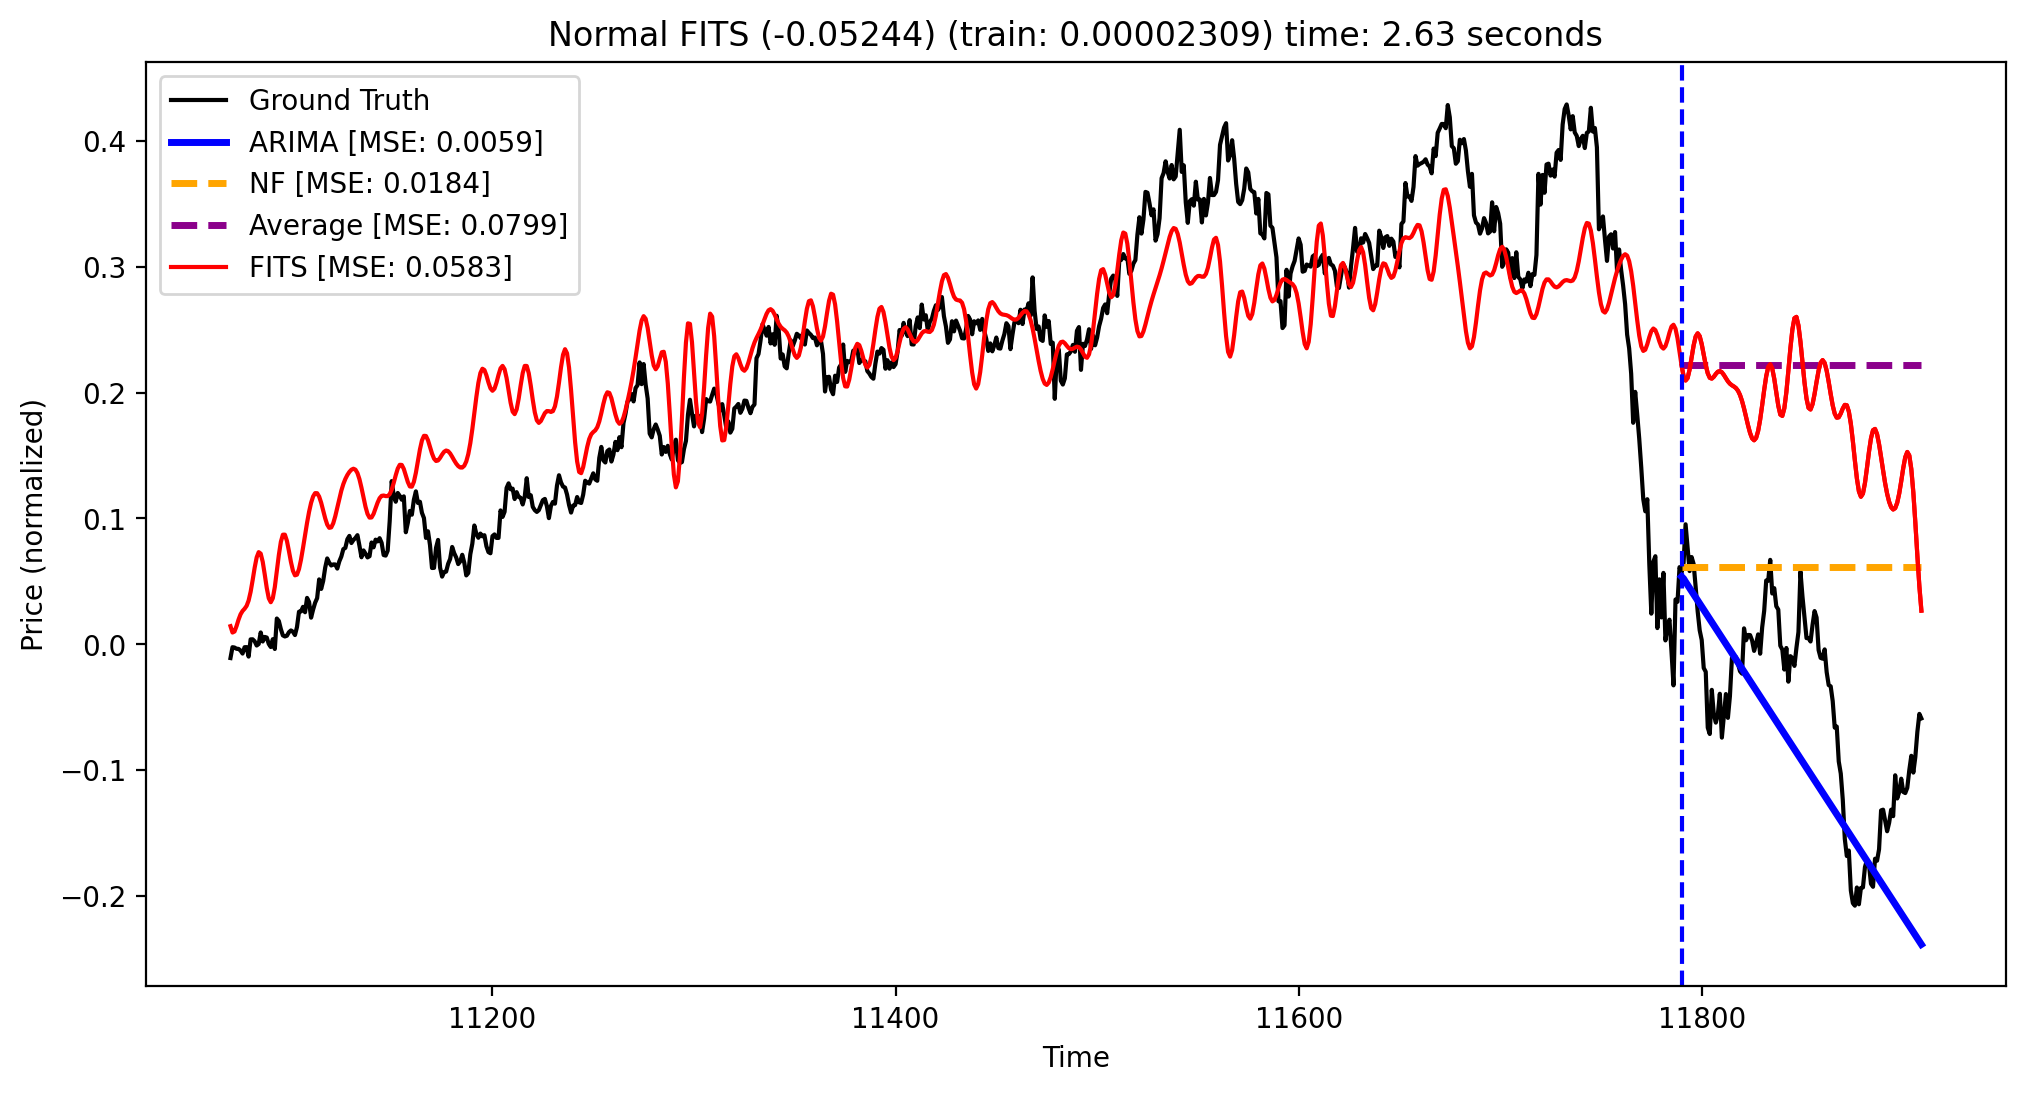

In [11]:
plot_normal_fits()

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=87, bias=True)
)
Parameters 6612
epoch: 0 loss: 0.00006148 val_loss: 0.00210948

epoch: 299 loss: 0.00001417 val_loss: 0.00030272

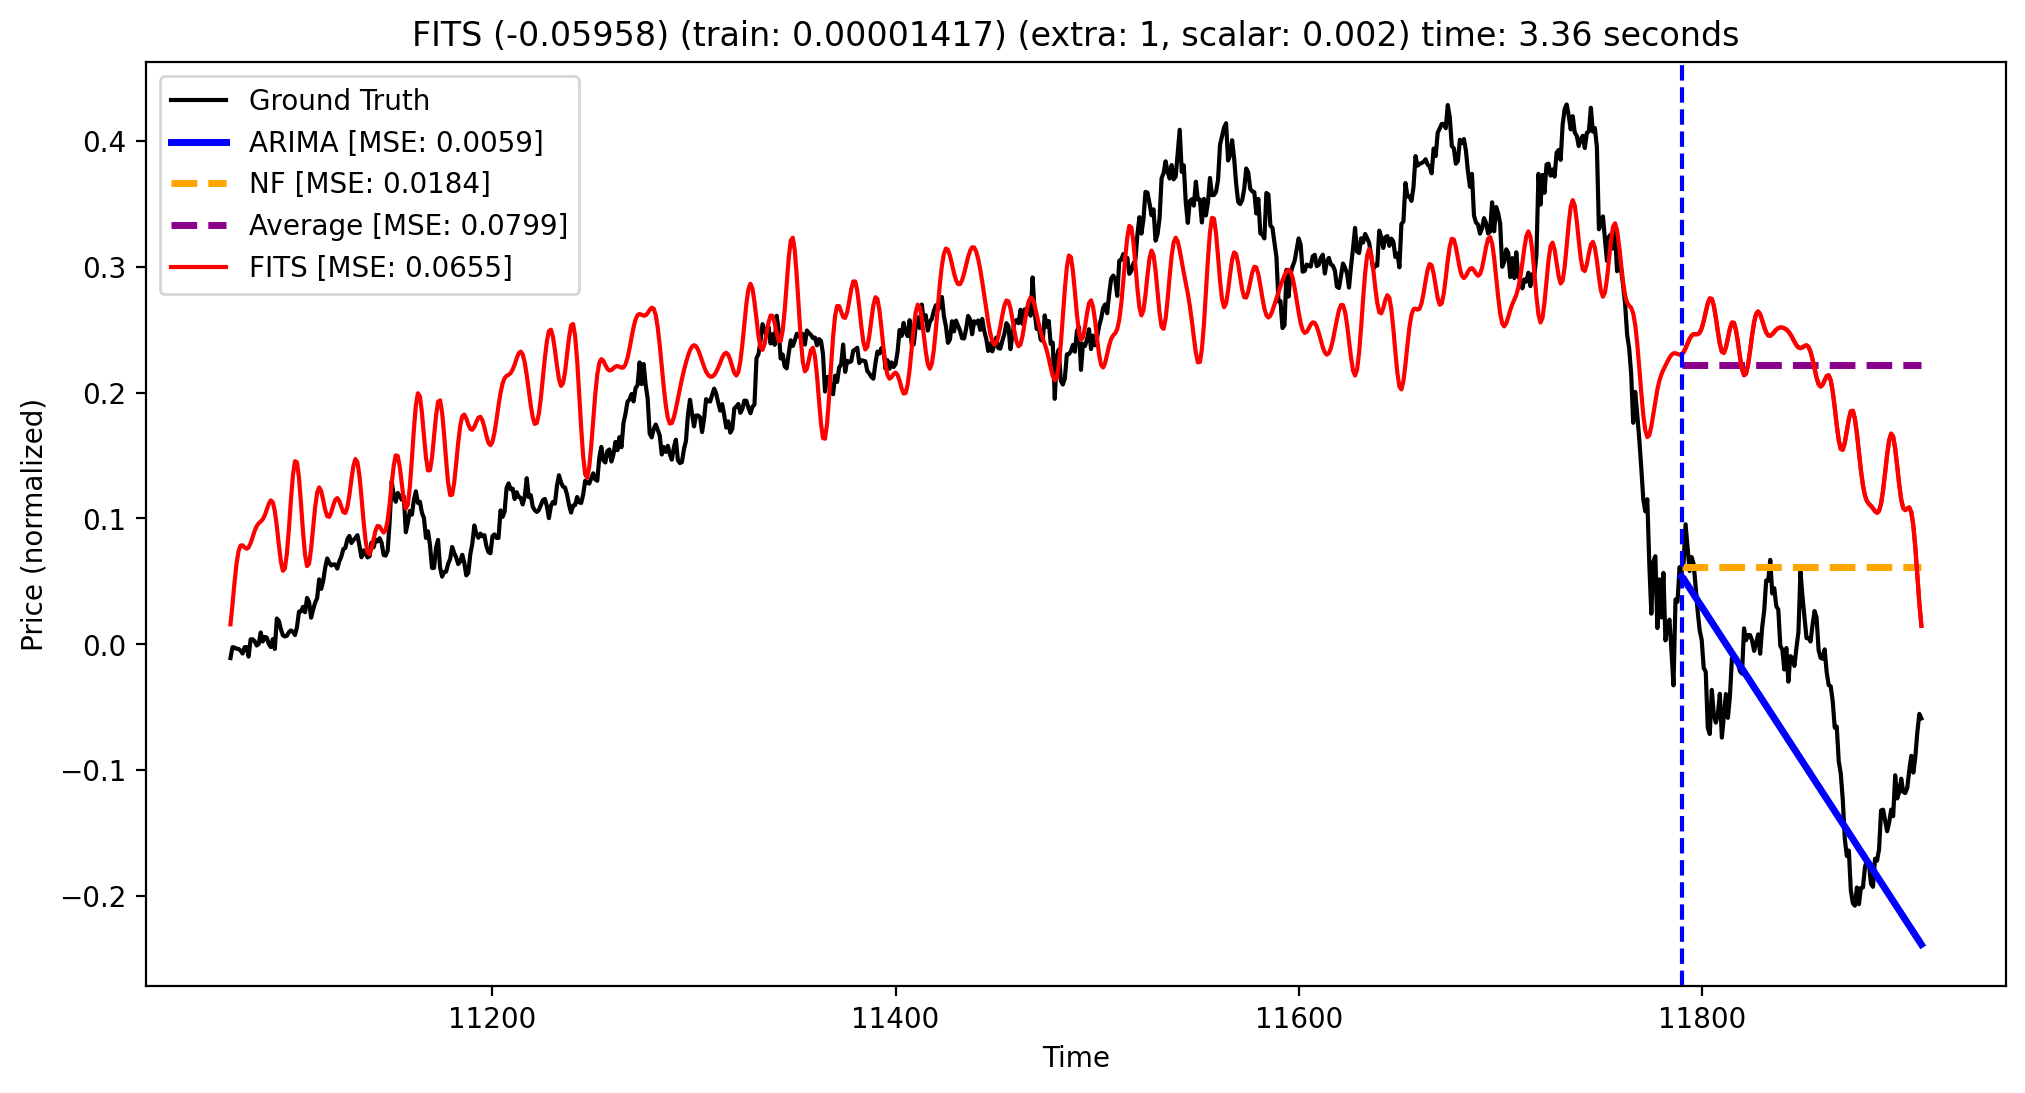

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=95, bias=True)
)
Parameters 7220
epoch: 299 loss: 0.00001467 val_loss: 0.00000421

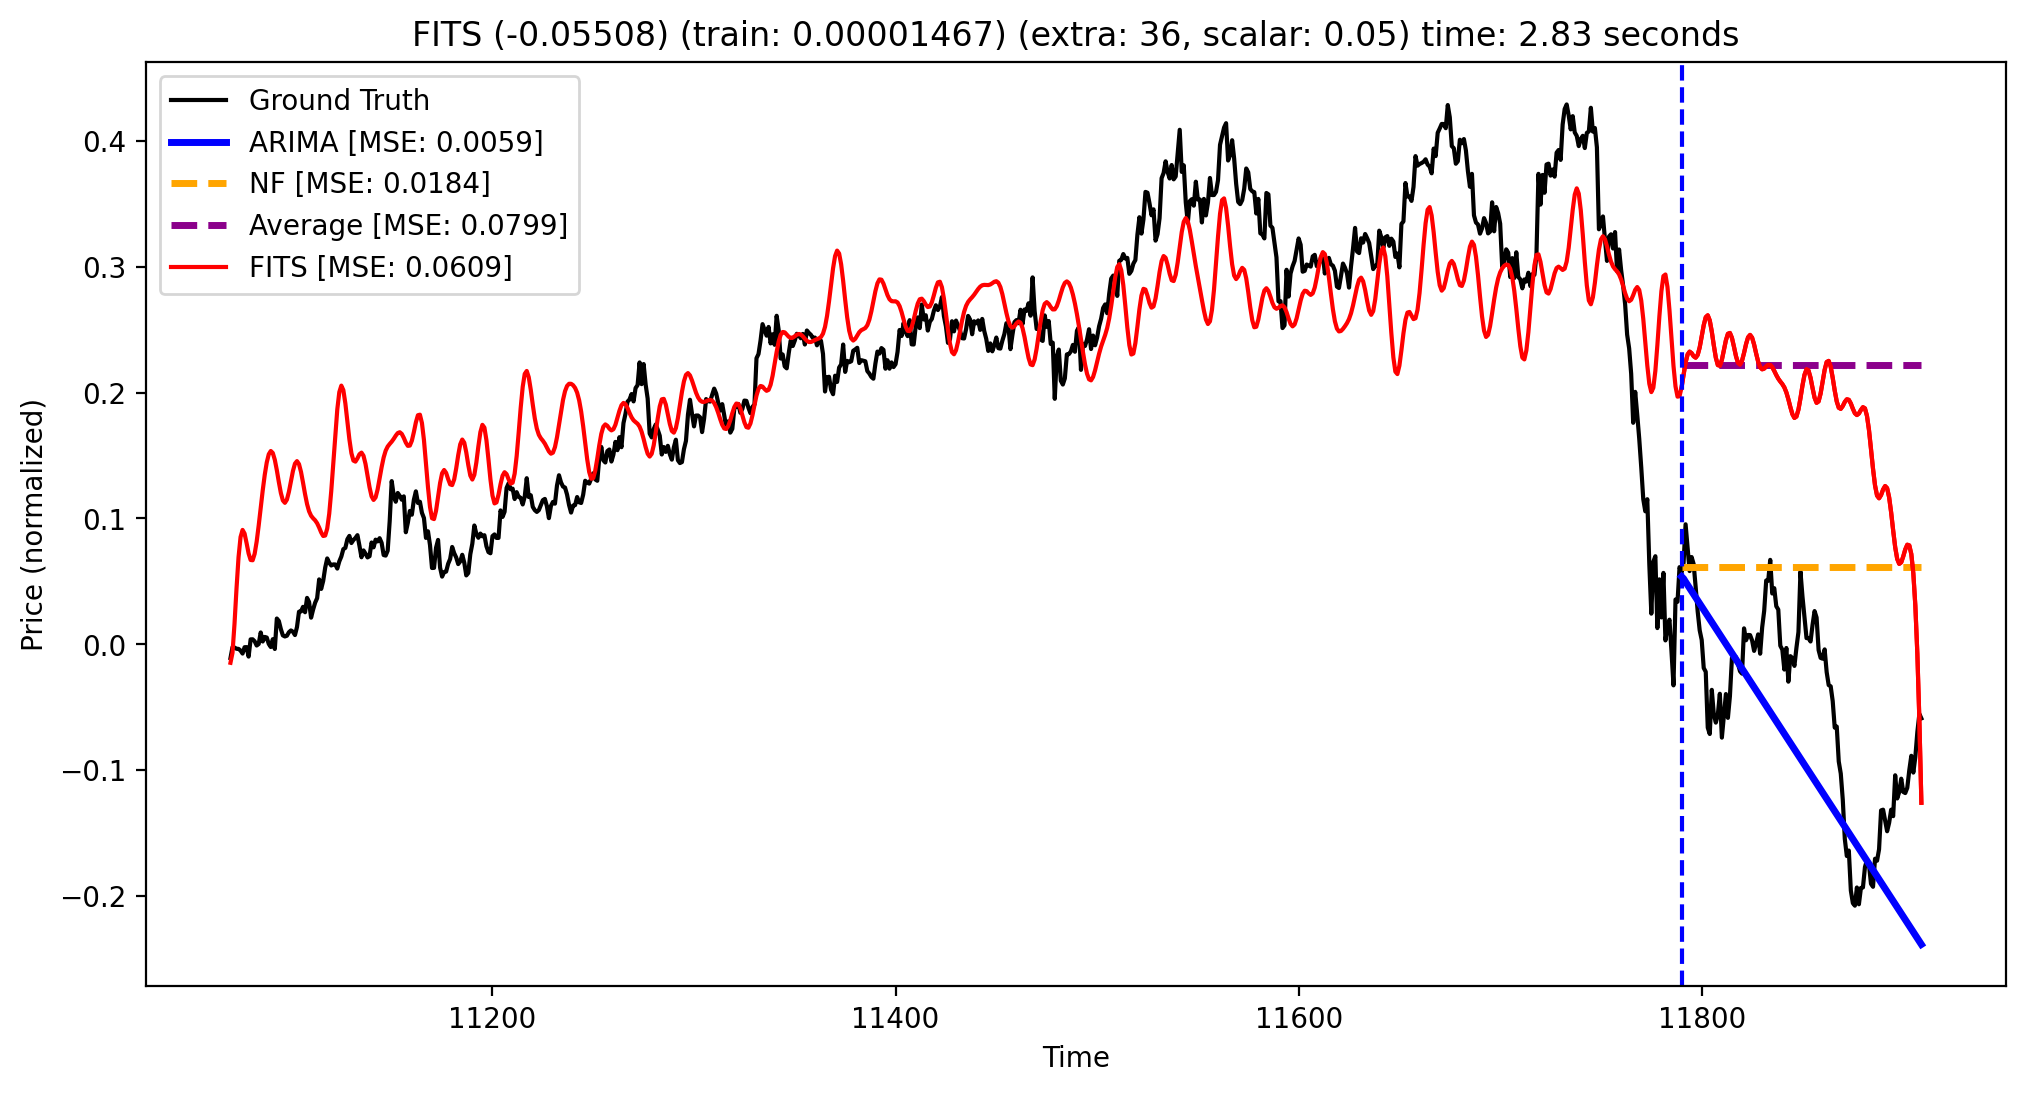

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=102, bias=True)
)
Parameters 7752
epoch: 299 loss: 0.00001200 val_loss: 0.00041953

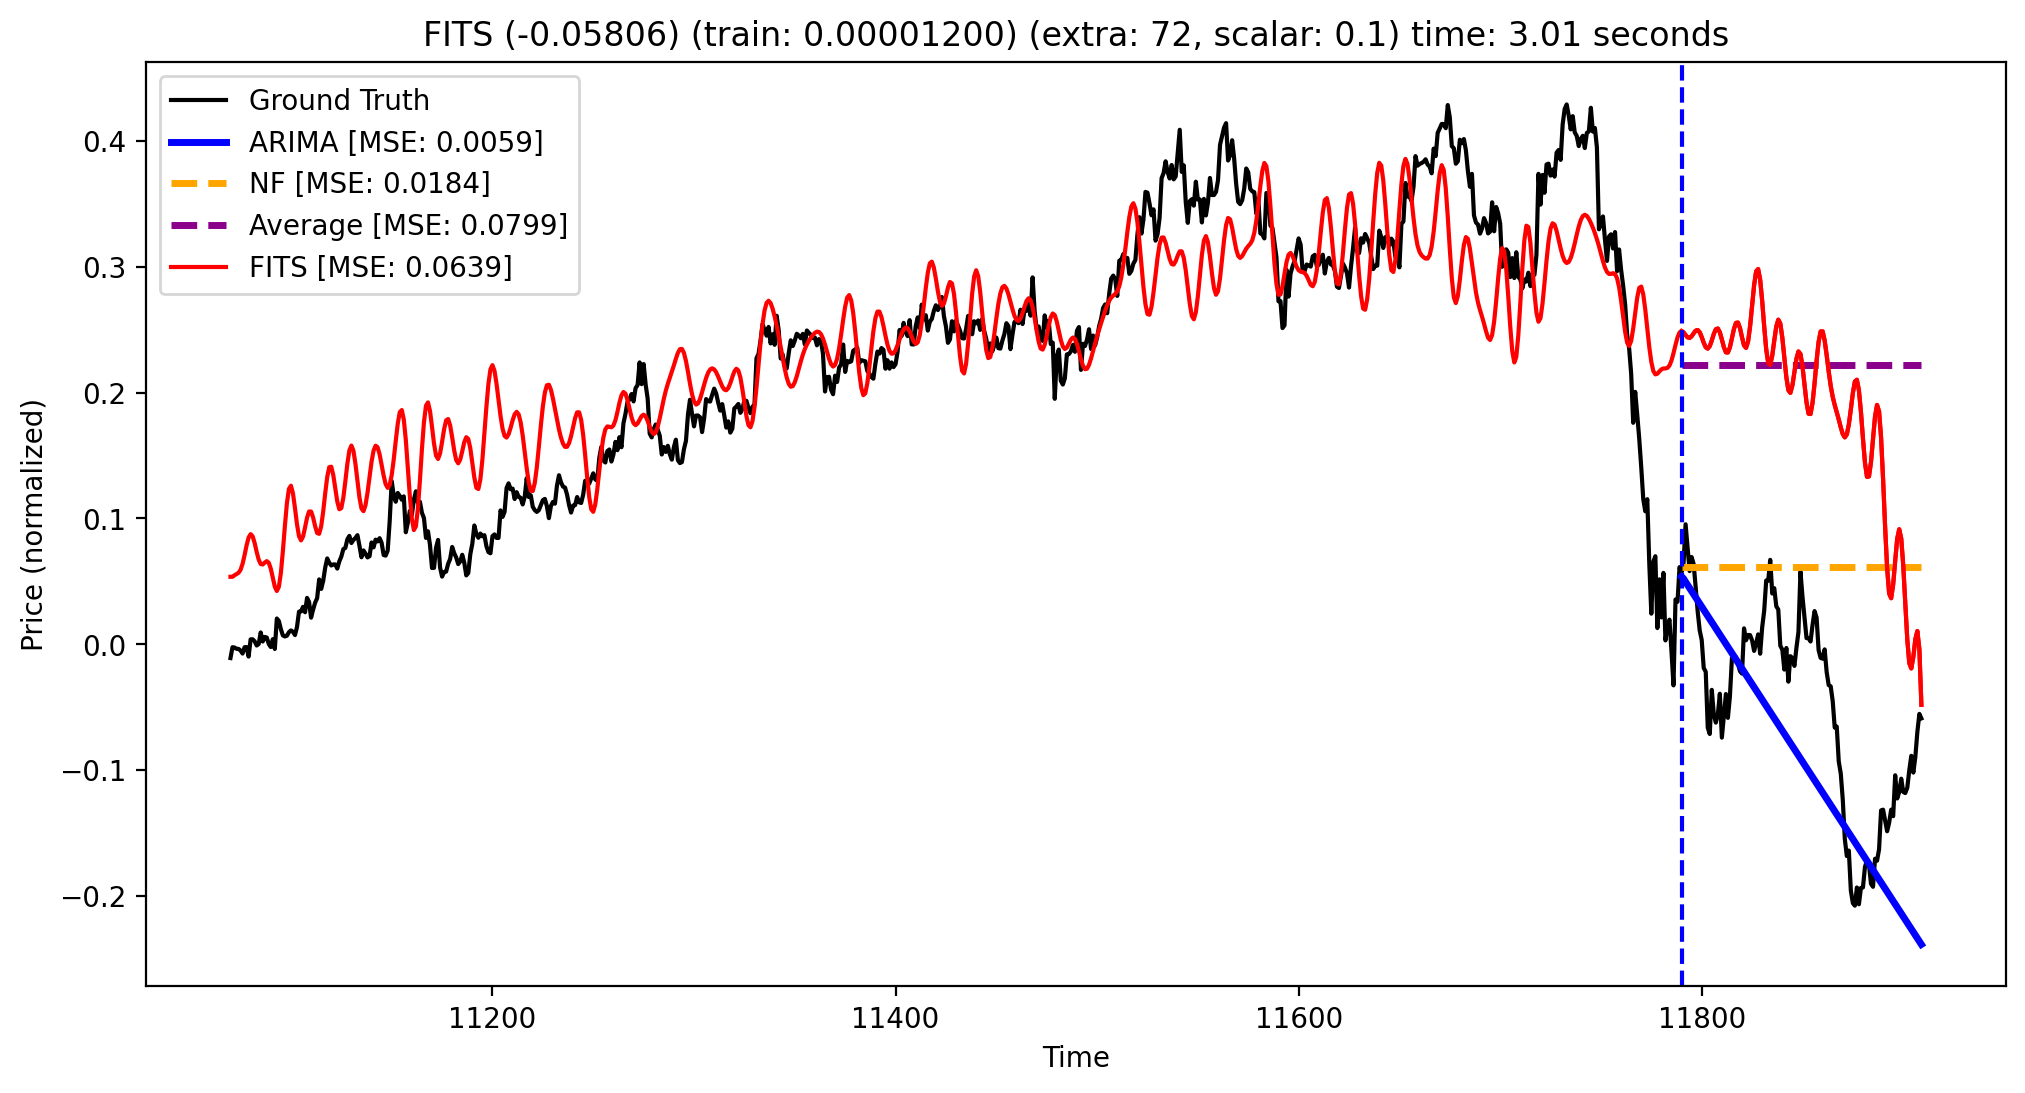

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=117, bias=True)
)
Parameters 8892
epoch: 299 loss: 0.00000996 val_loss: 0.00030680

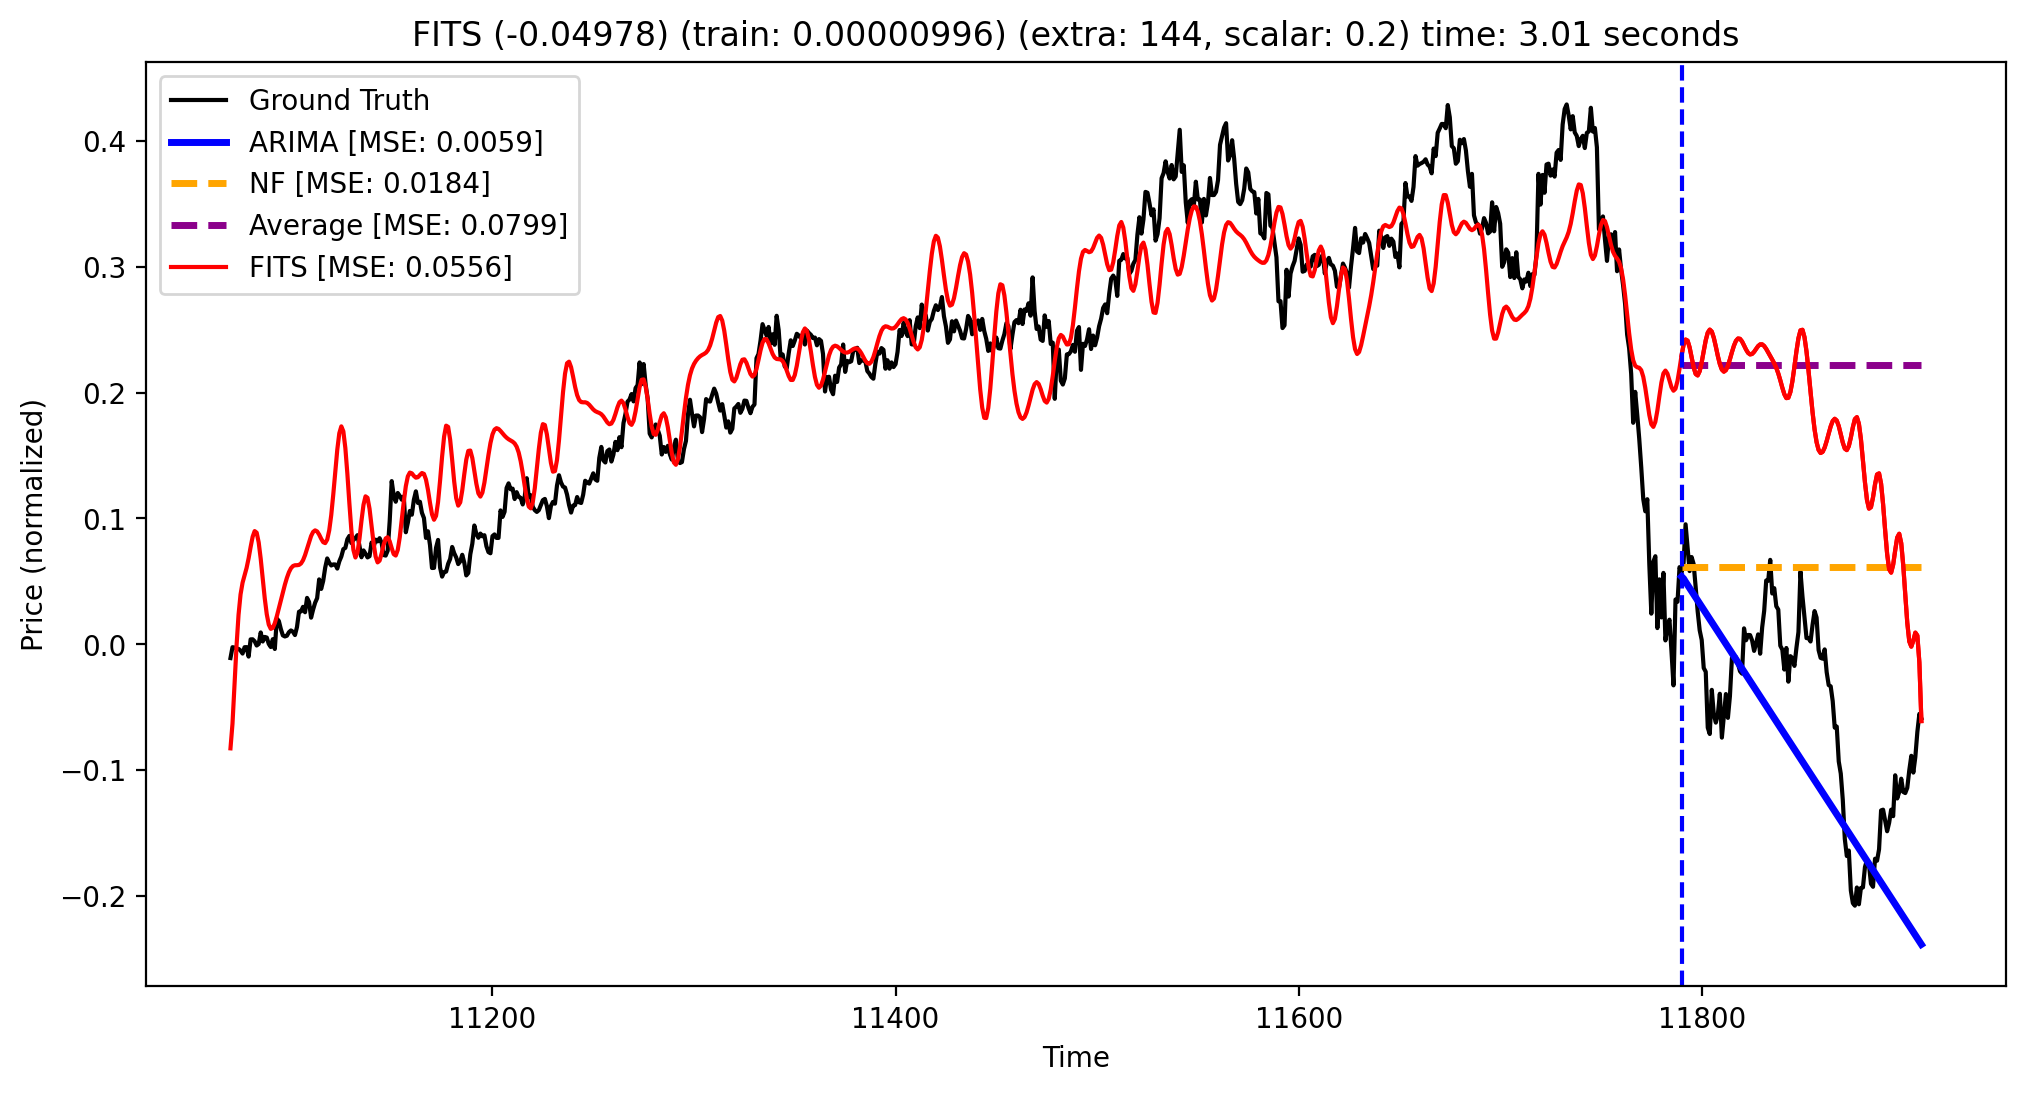

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=335, bias=True)
)
Parameters 25460
epoch: 299 loss: 0.00000359 val_loss: 0.00025905

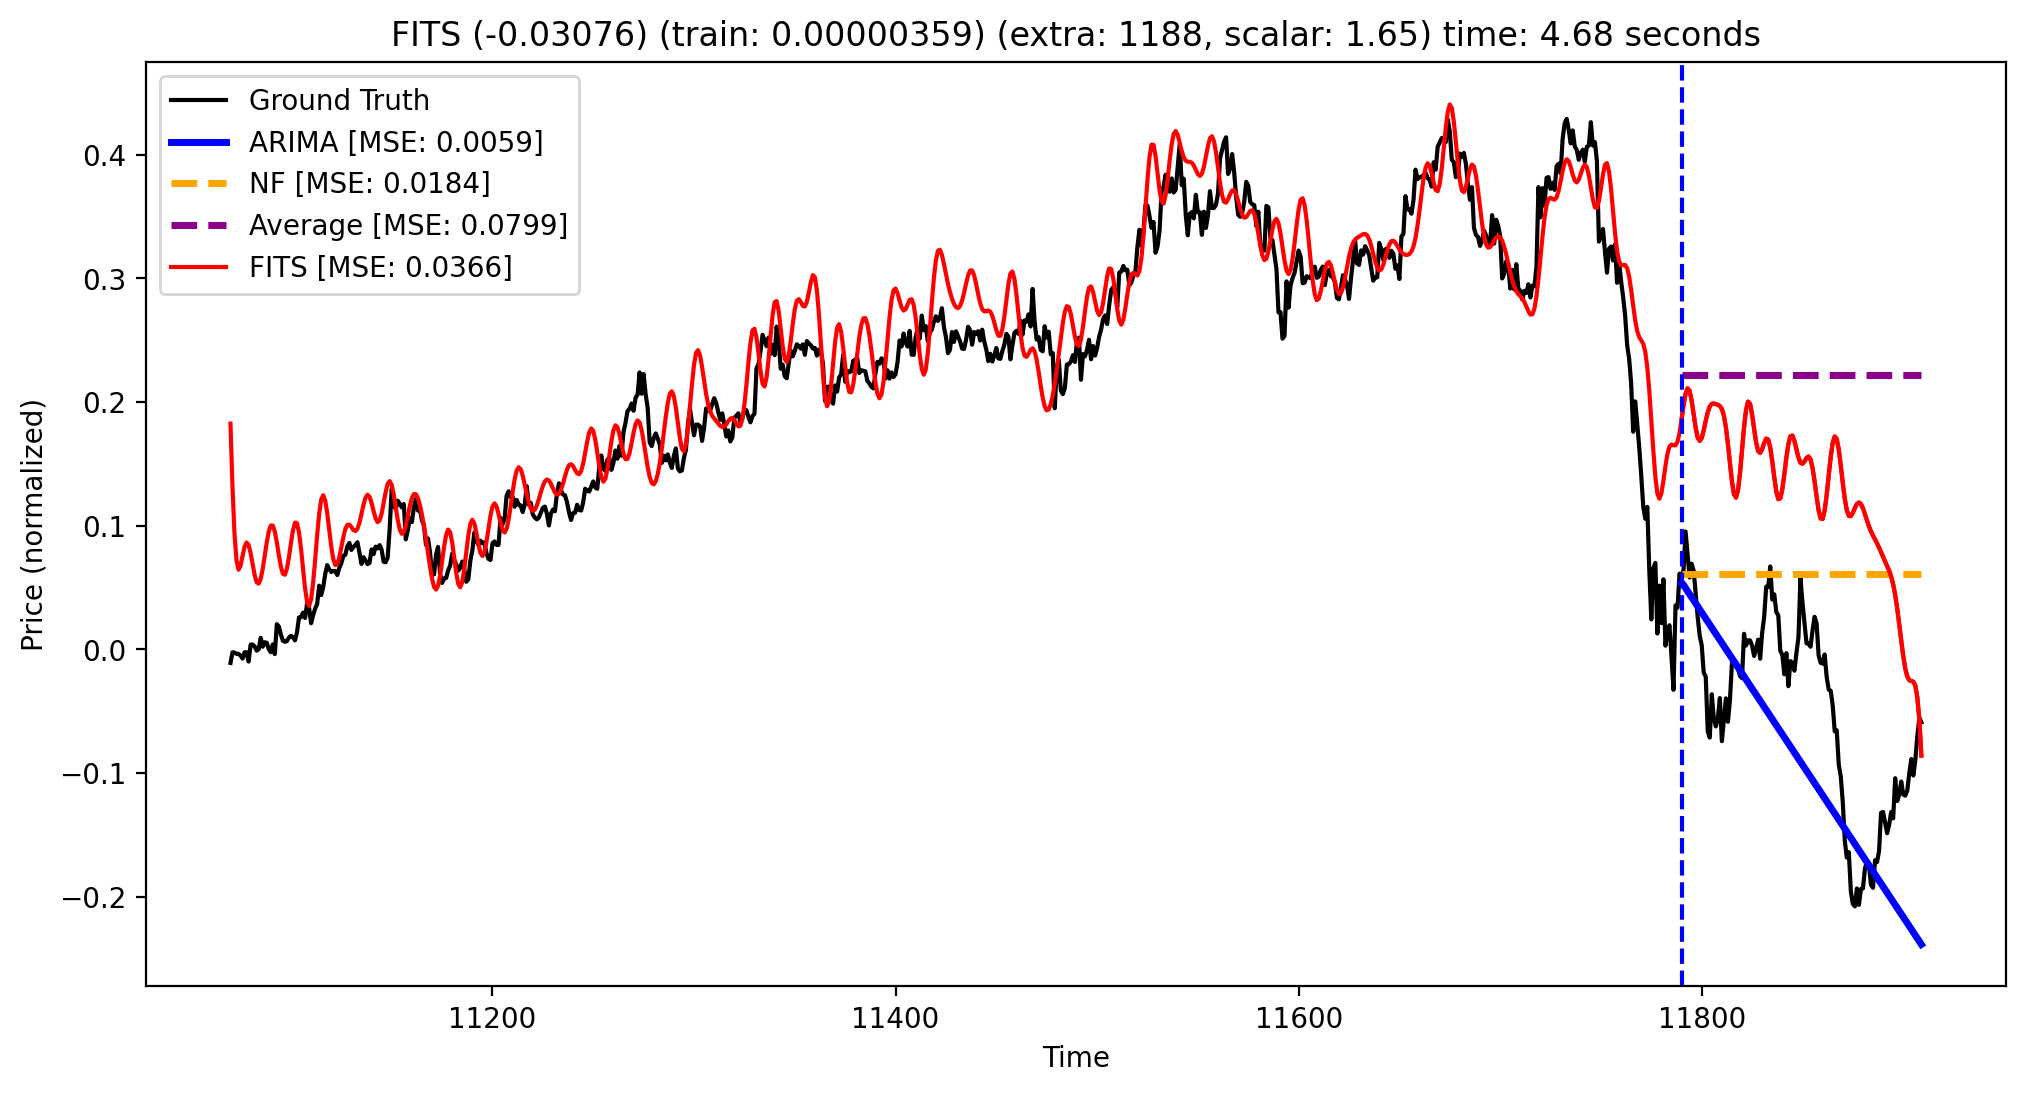

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=380, bias=True)
)
Parameters 28880
epoch: 299 loss: 0.00000812 val_loss: 0.00002706

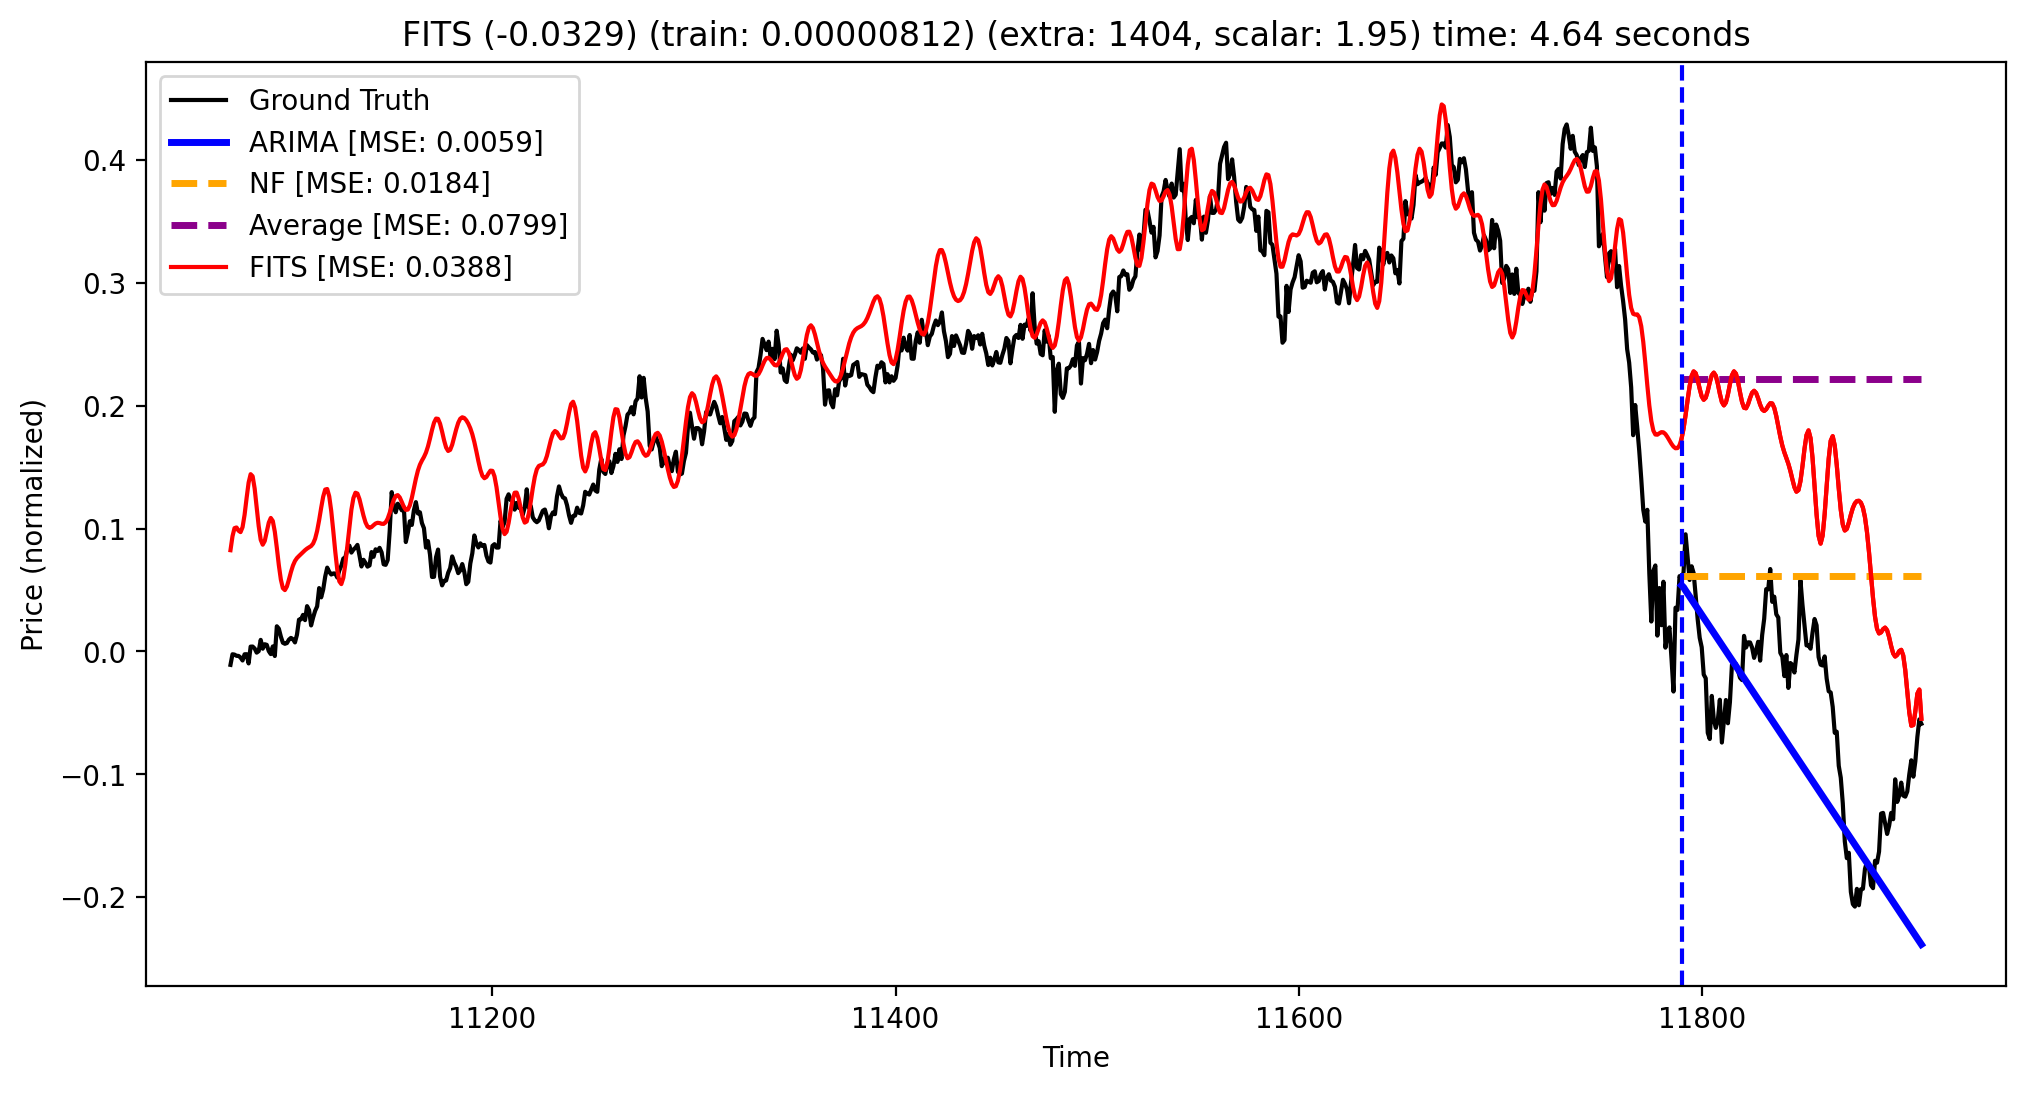

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=545, bias=True)
)
Parameters 41420
epoch: 299 loss: 0.00000371 val_loss: 0.00022720

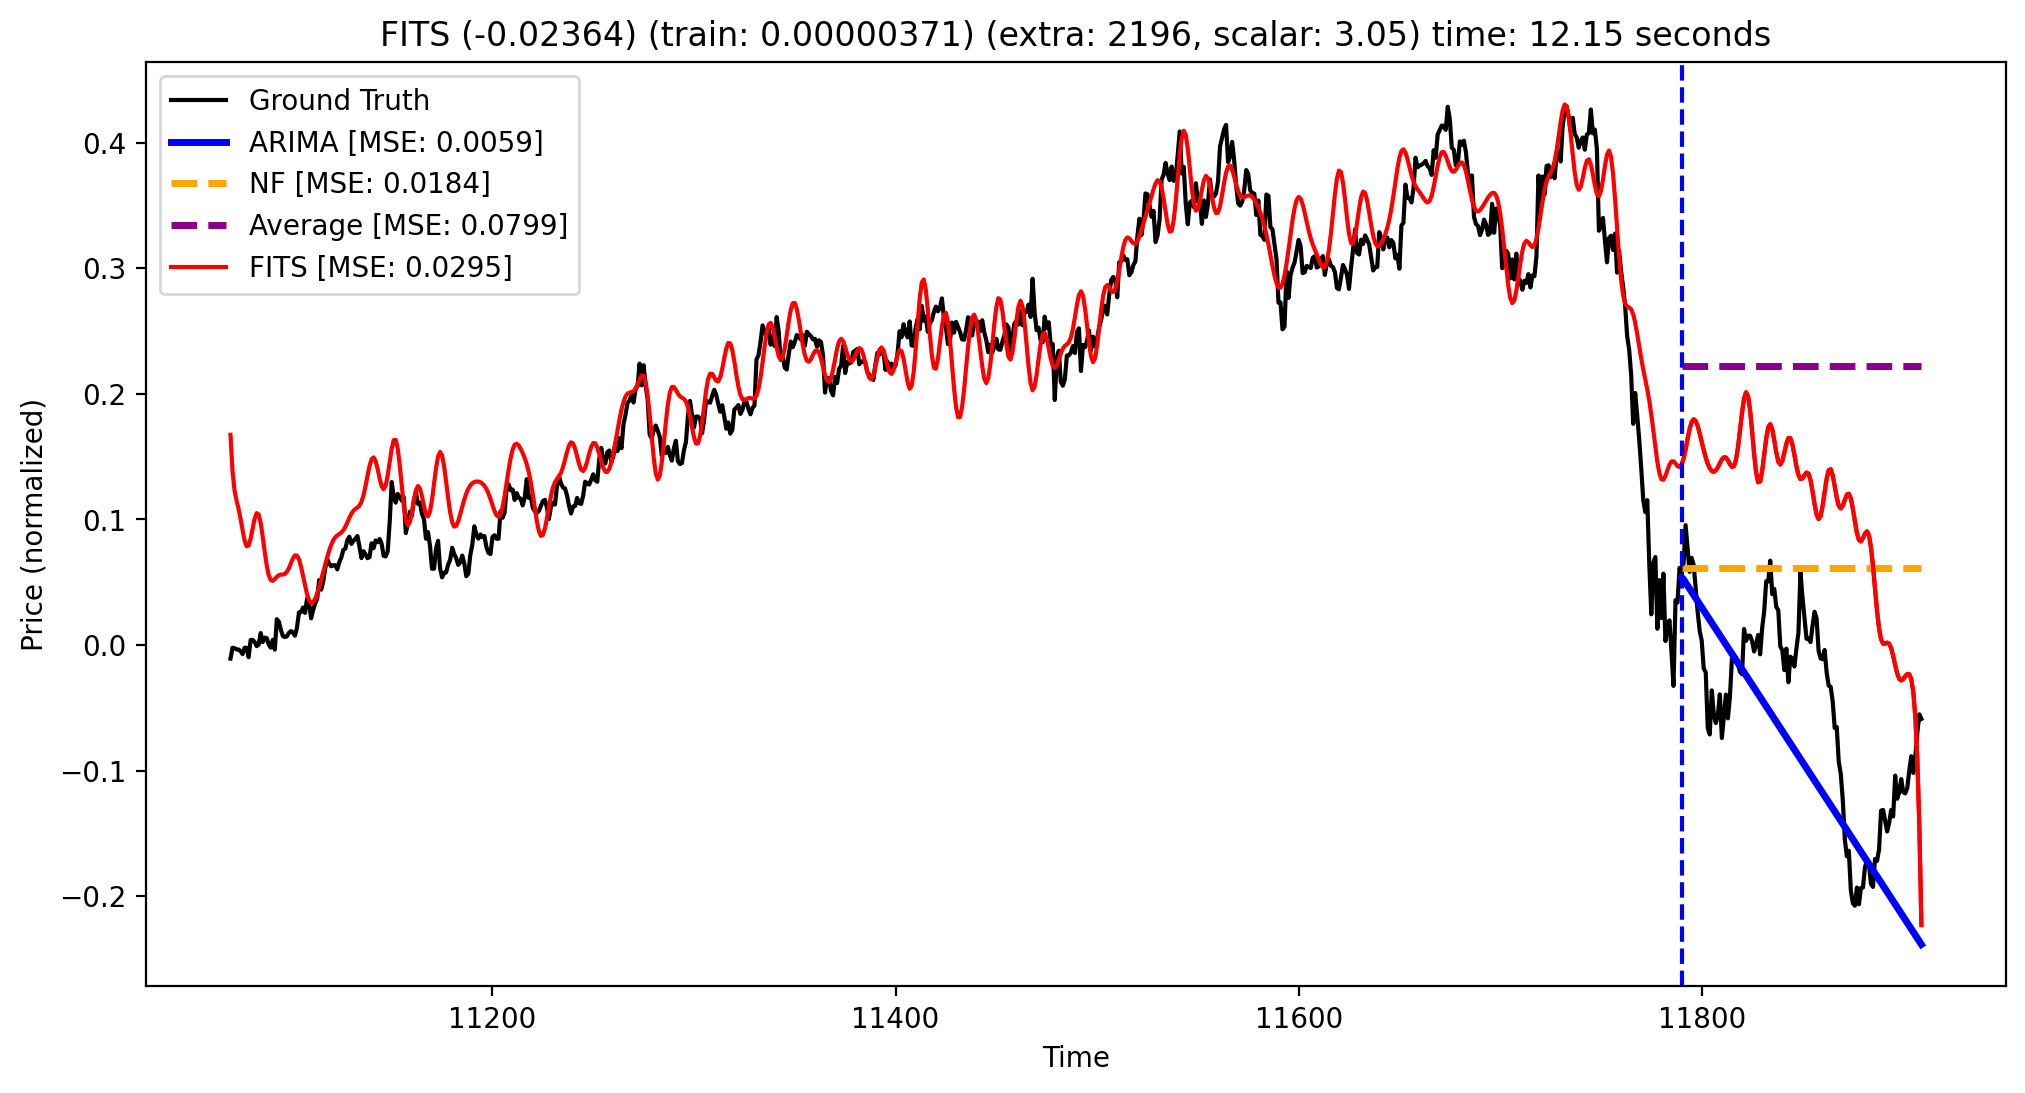

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=687, bias=True)
)
Parameters 52212
epoch: 299 loss: 0.00000558 val_loss: 0.00000267

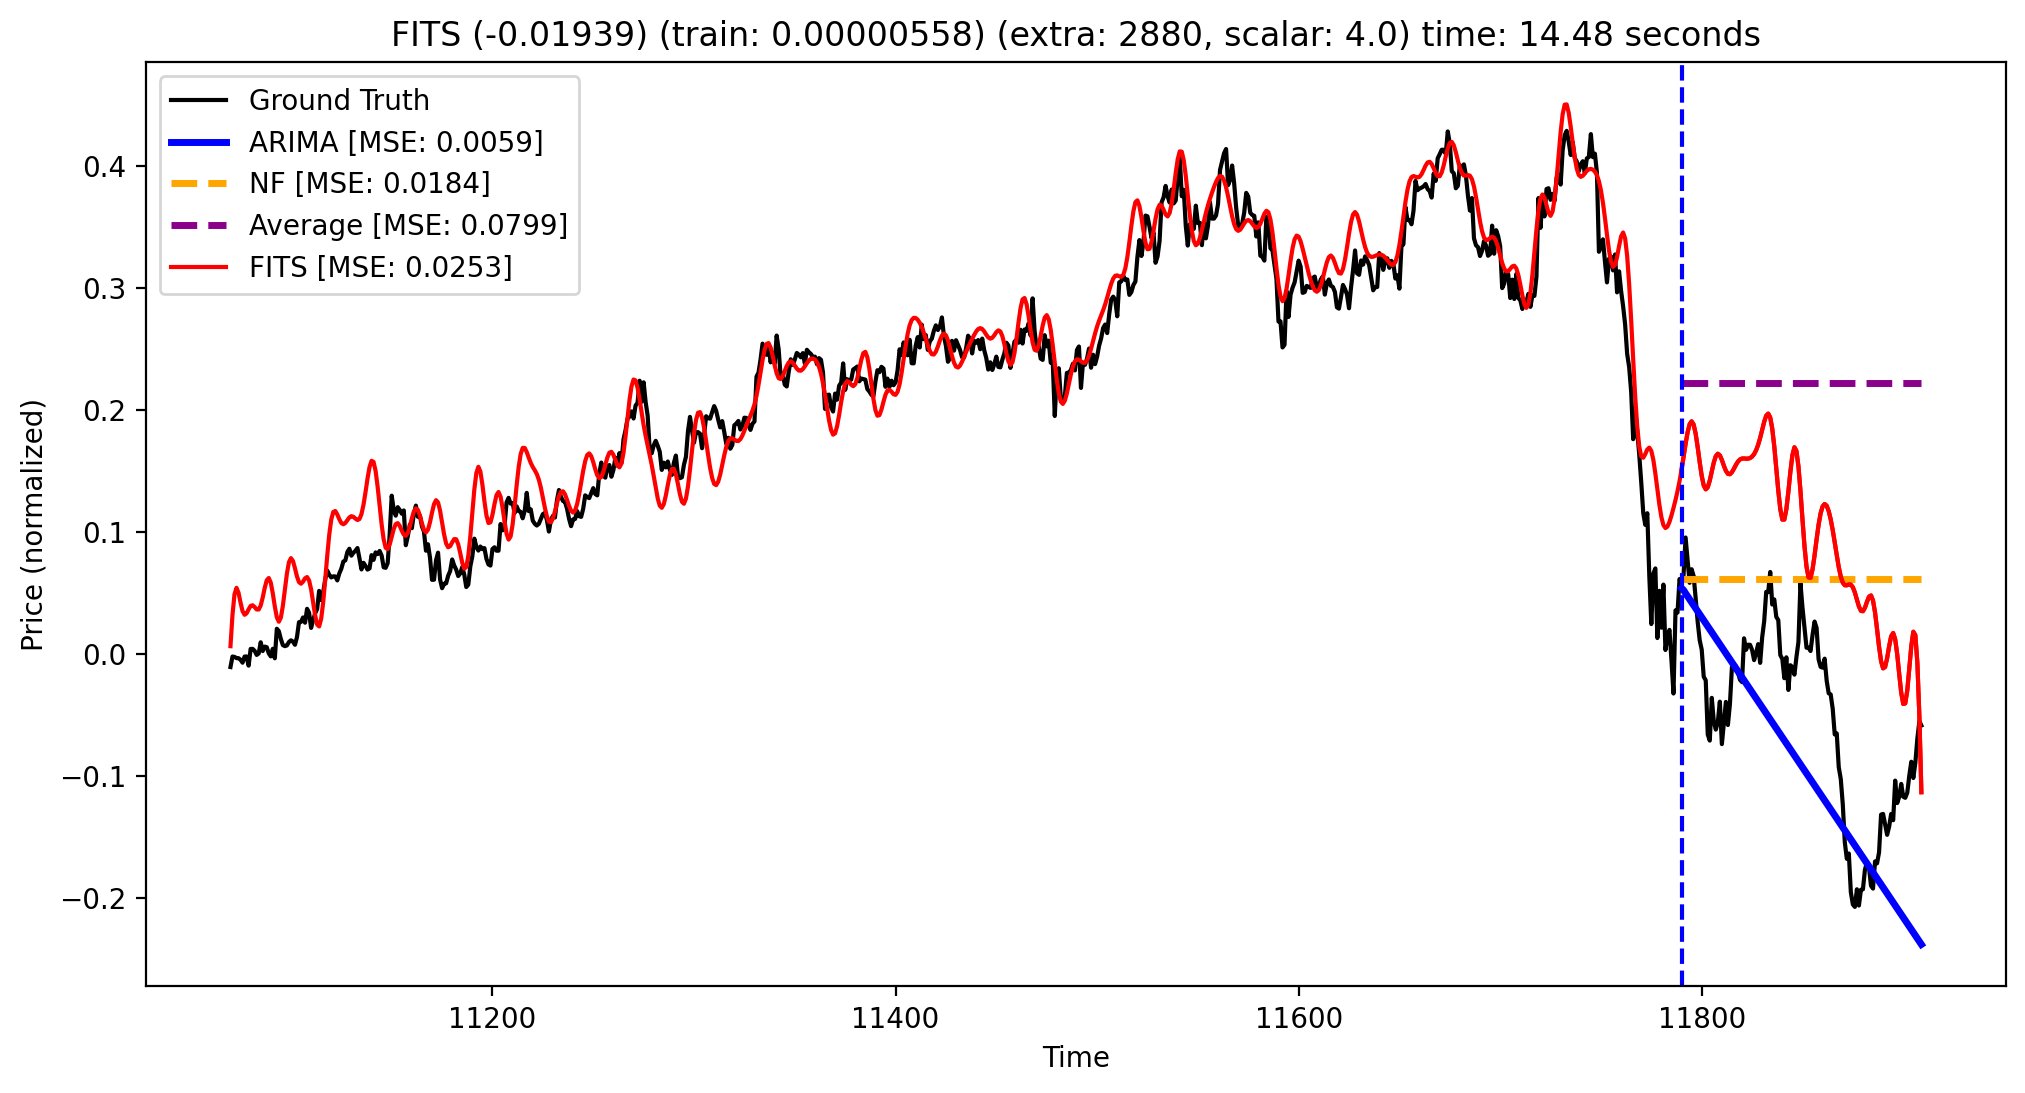

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=837, bias=True)
)
Parameters 63612
epoch: 299 loss: 0.00000450 val_loss: 0.00000832

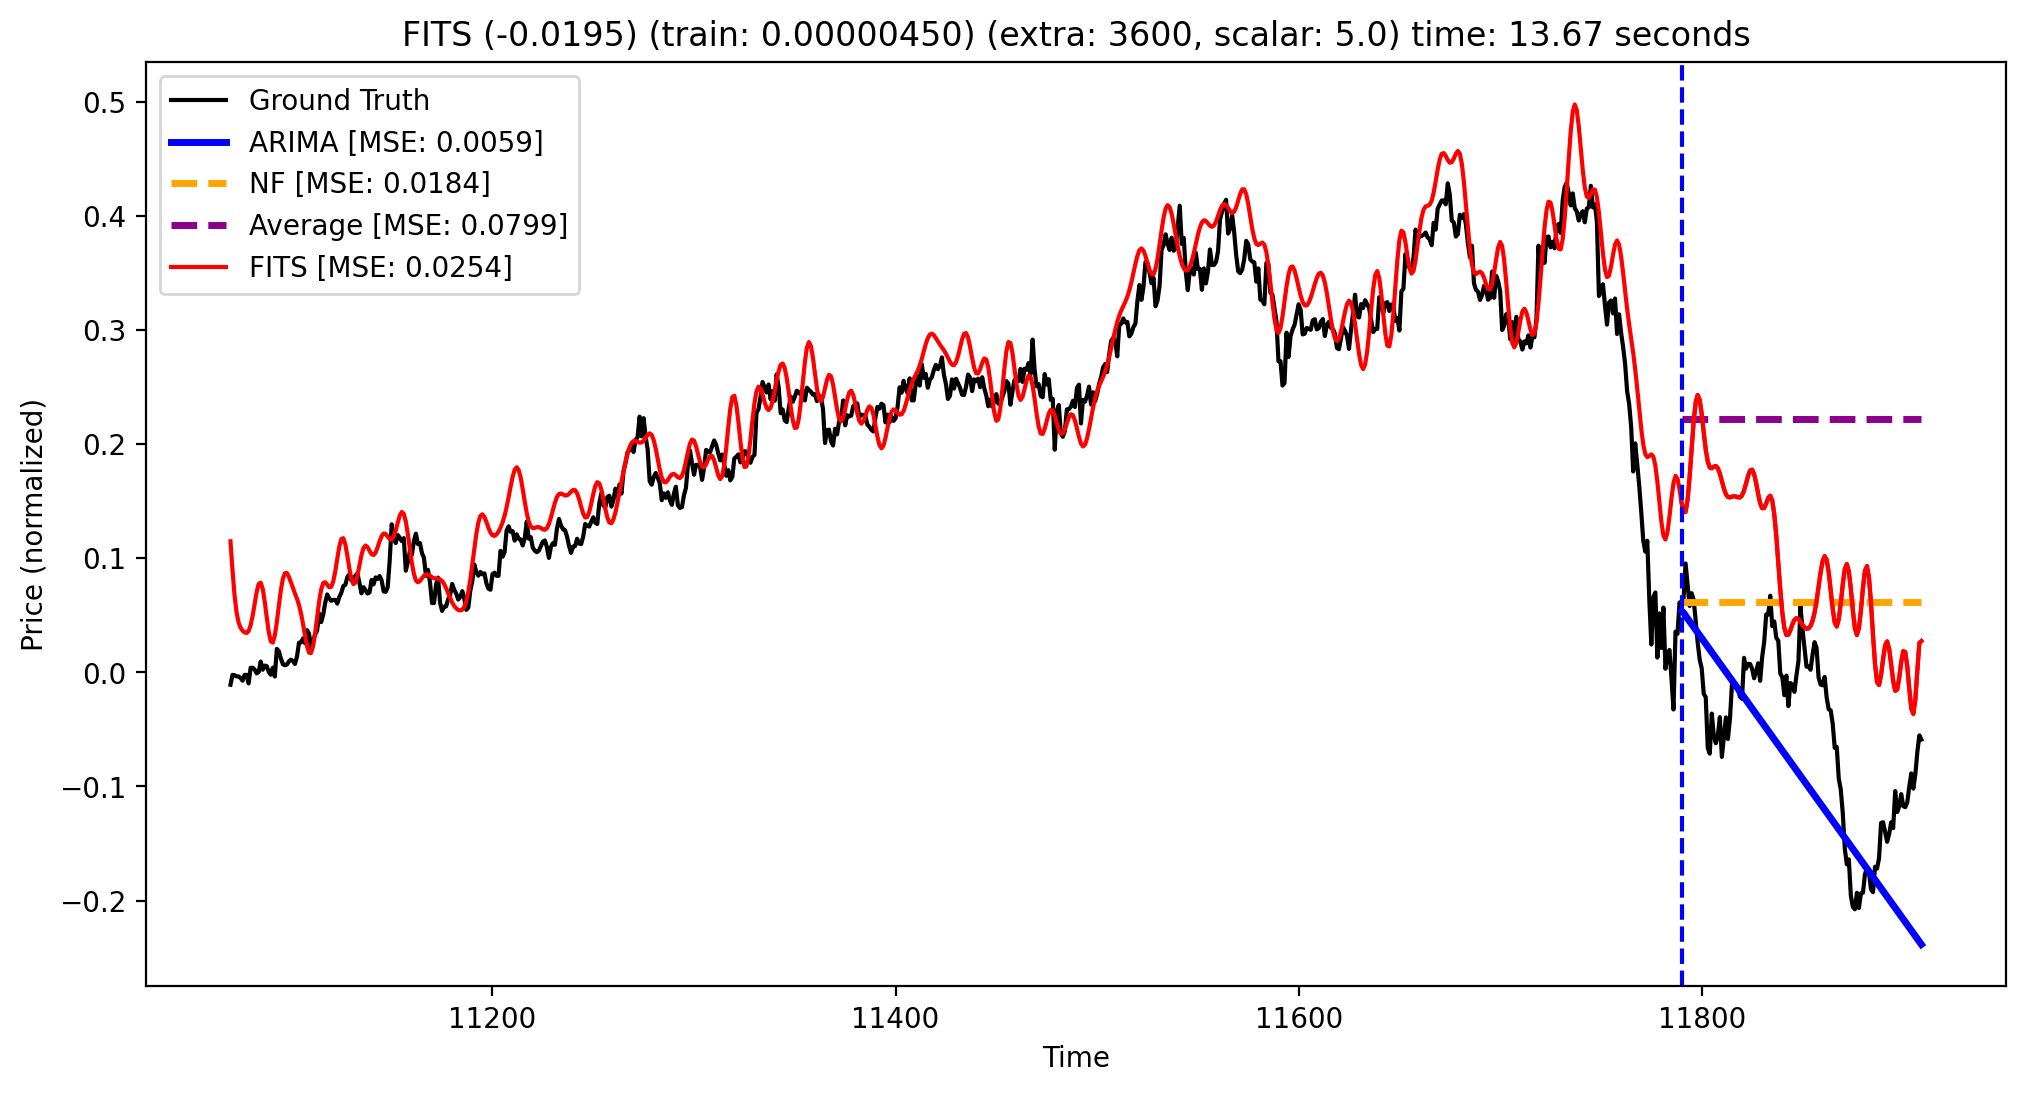

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=987, bias=True)
)
Parameters 75012
epoch: 299 loss: 0.00000489 val_loss: 0.00000821

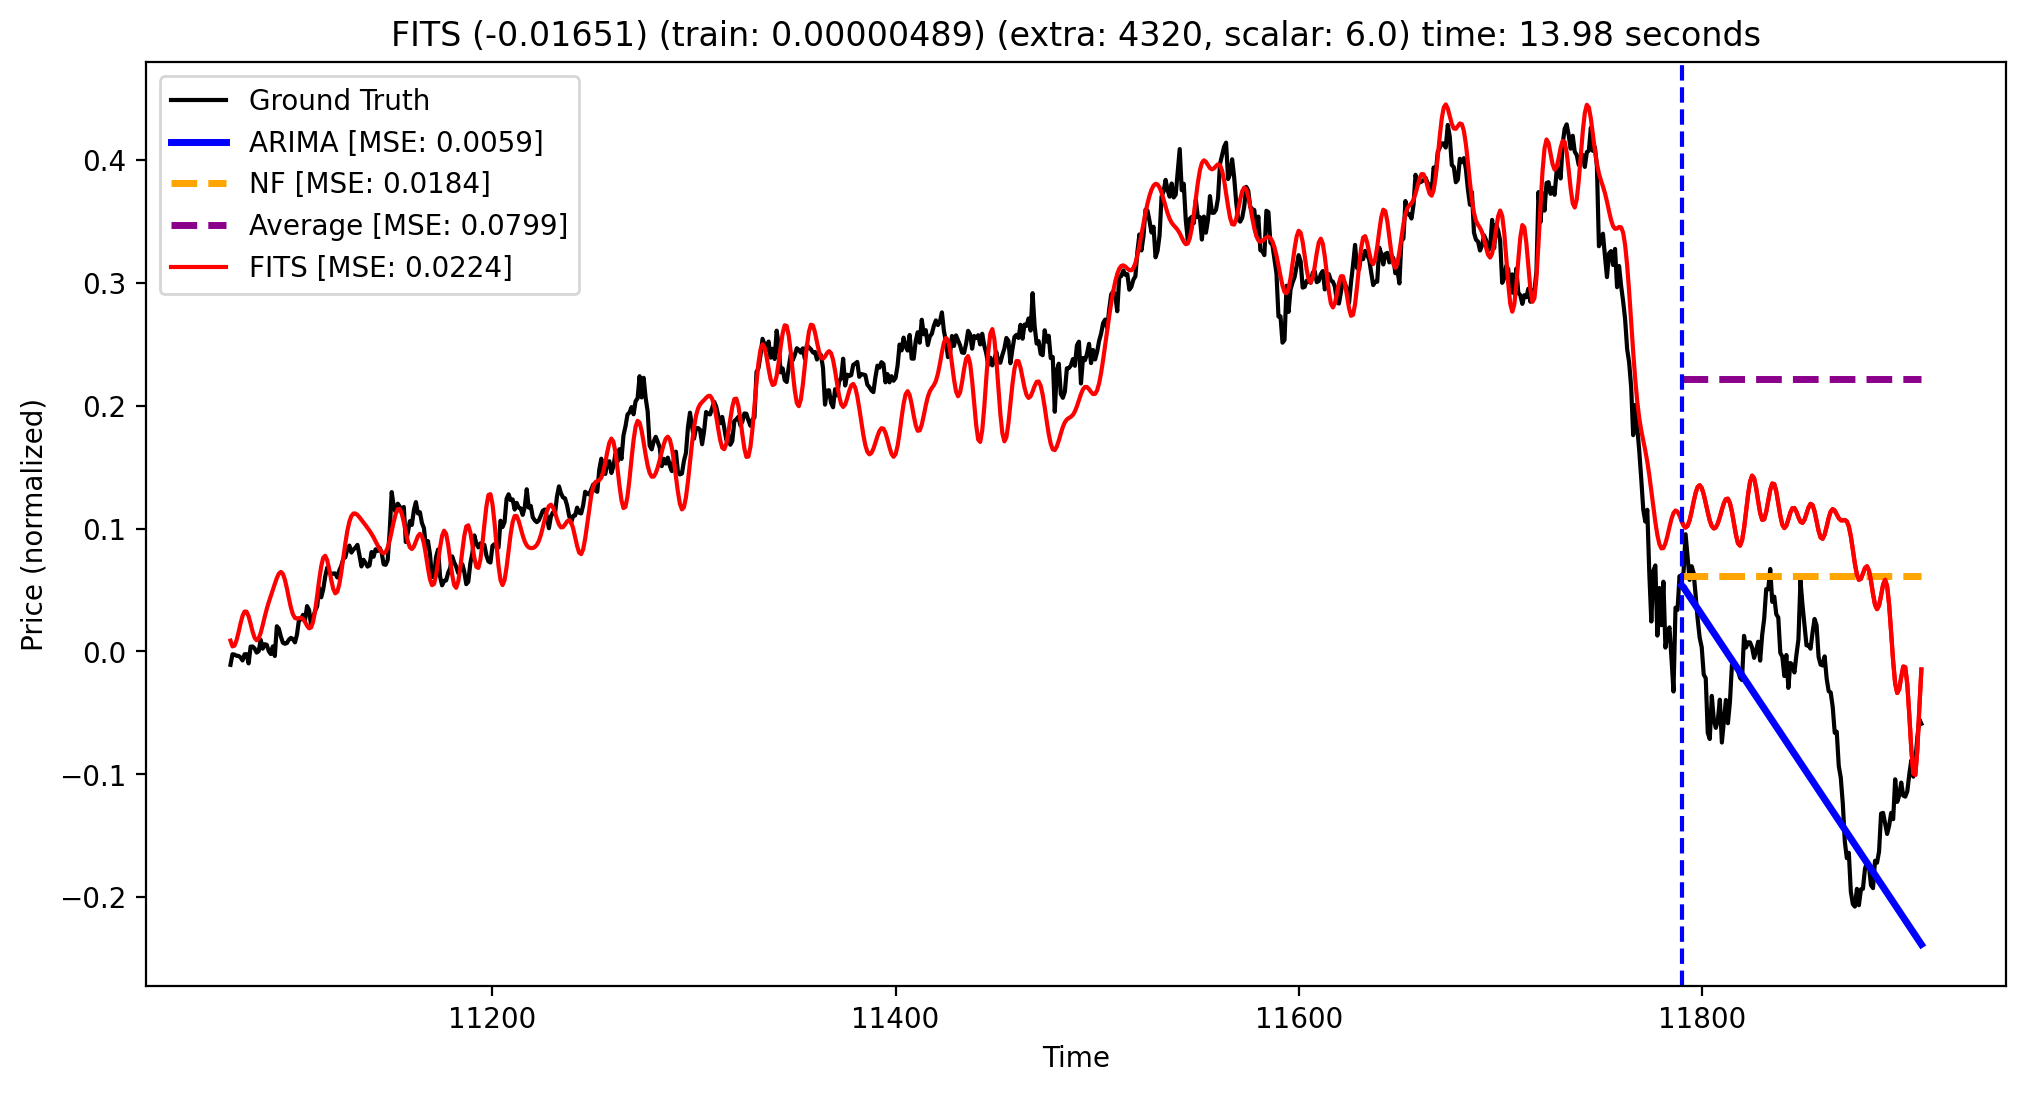

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=1137, bias=True)
)
Parameters 86412
epoch: 299 loss: 0.00000541 val_loss: 0.00009574

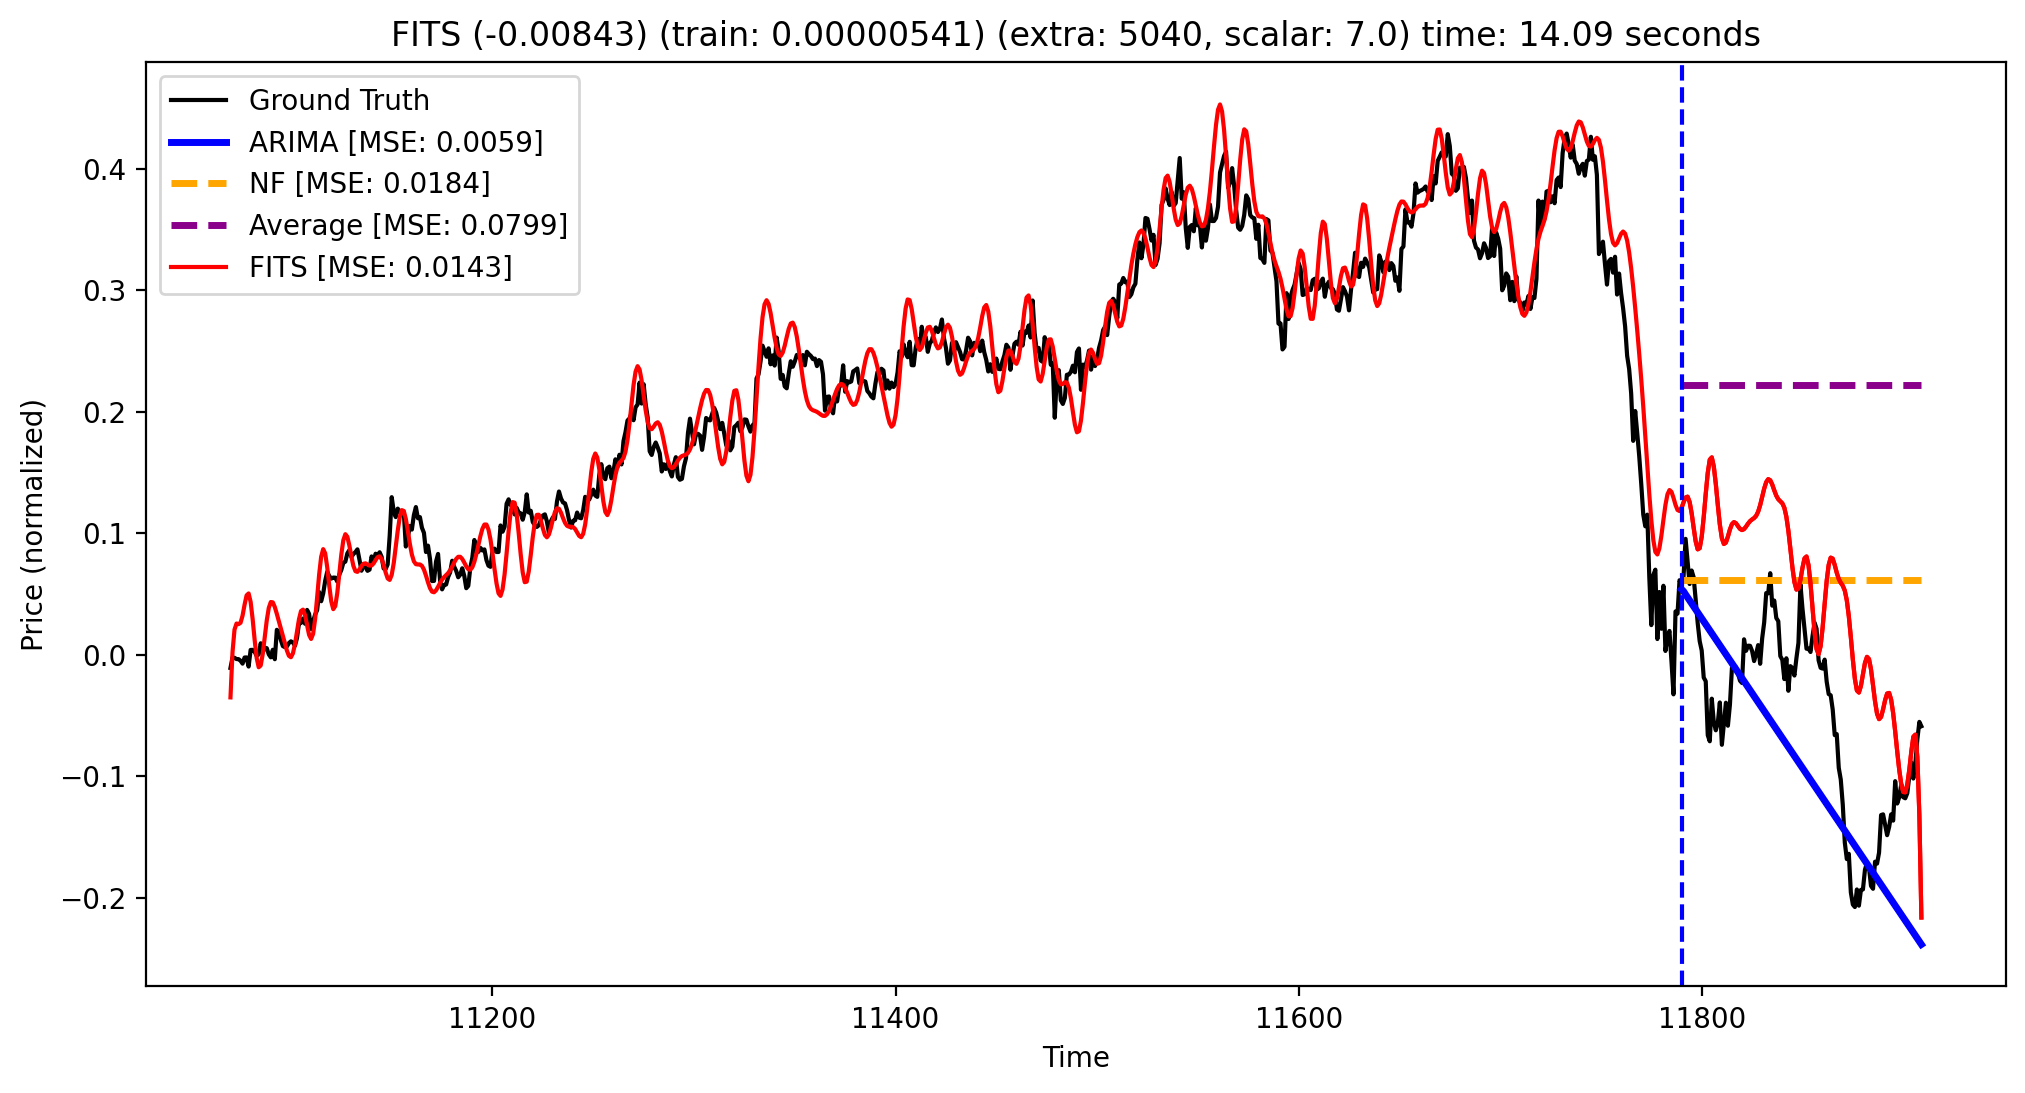

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=1287, bias=True)
)
Parameters 97812
epoch: 299 loss: 0.00000639 val_loss: 0.00020149

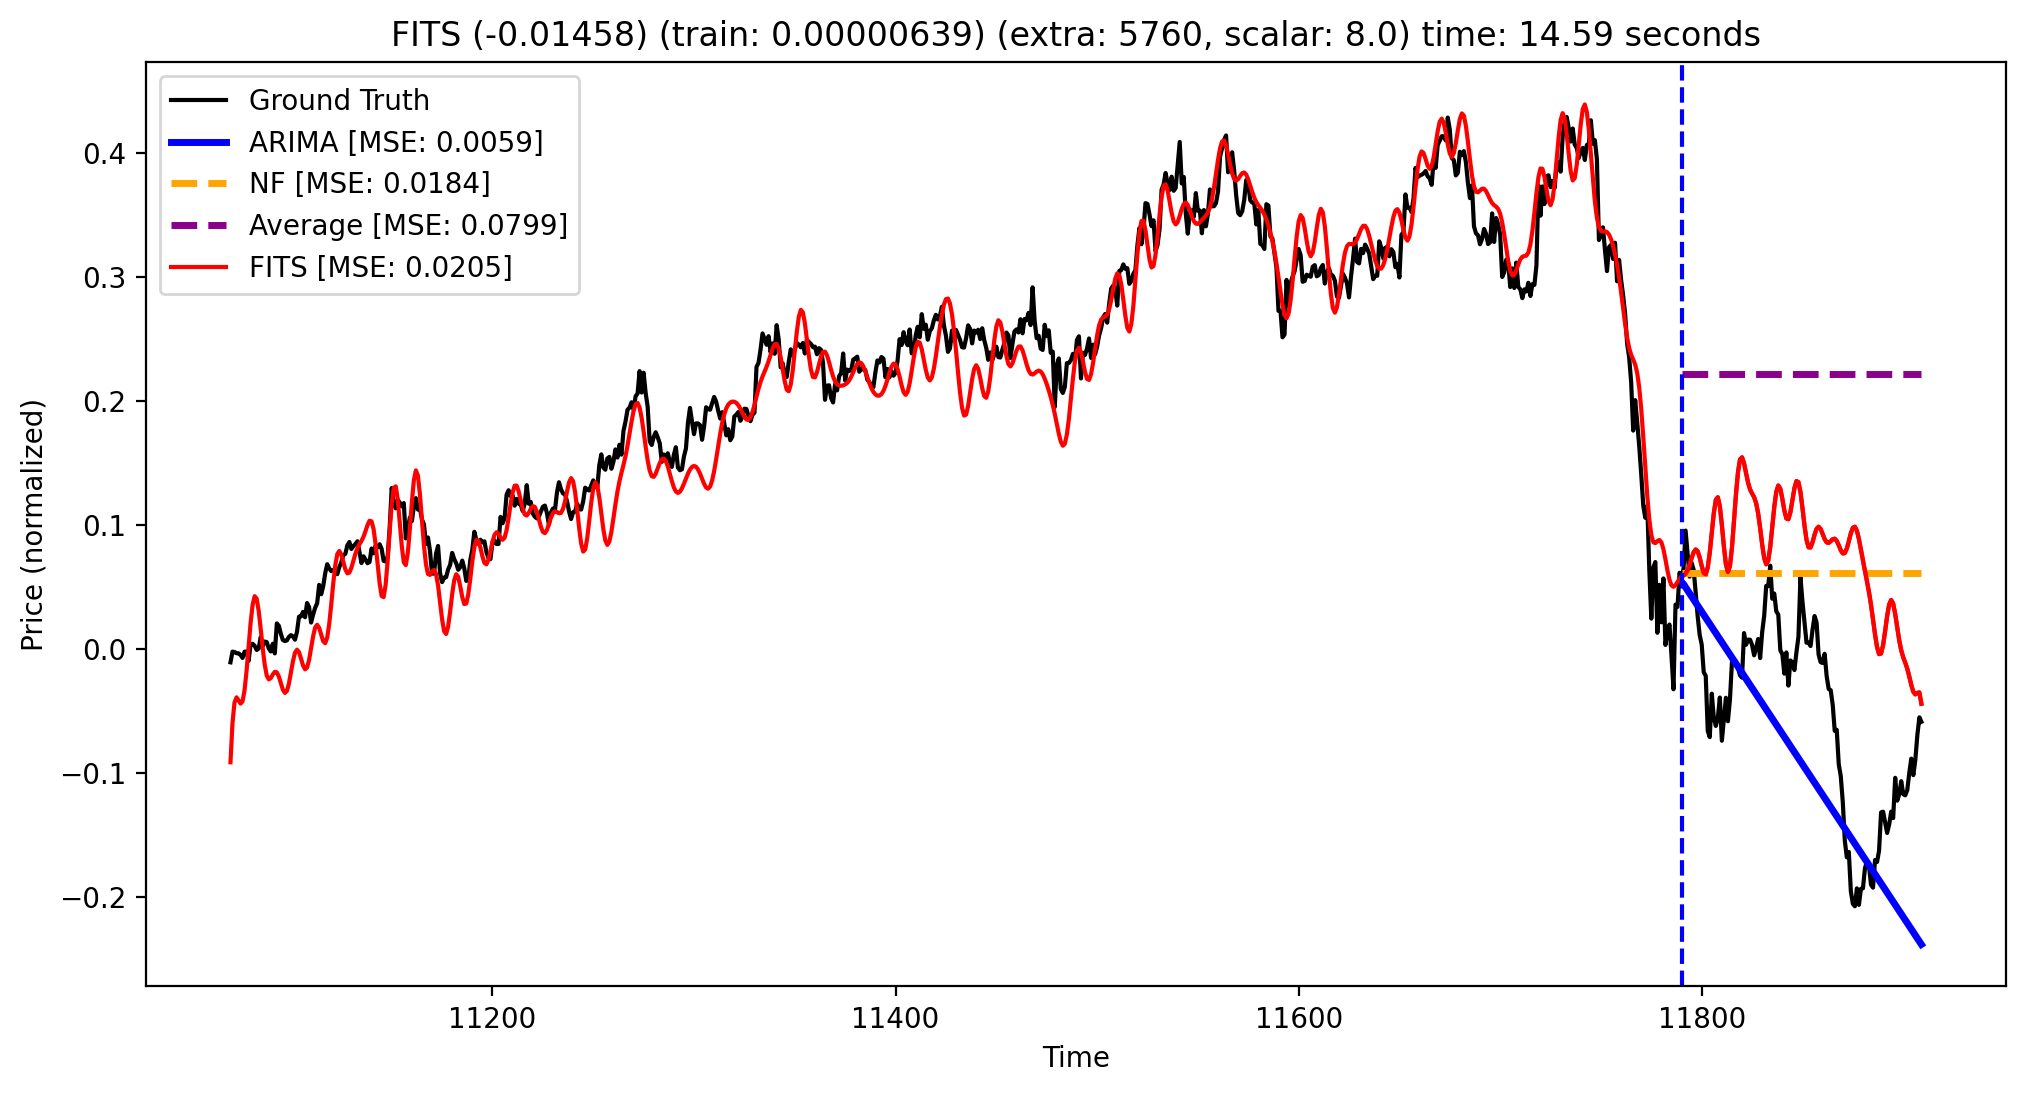

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=1437, bias=True)
)
Parameters 109212
epoch: 299 loss: 0.00000926 val_loss: 0.00035271

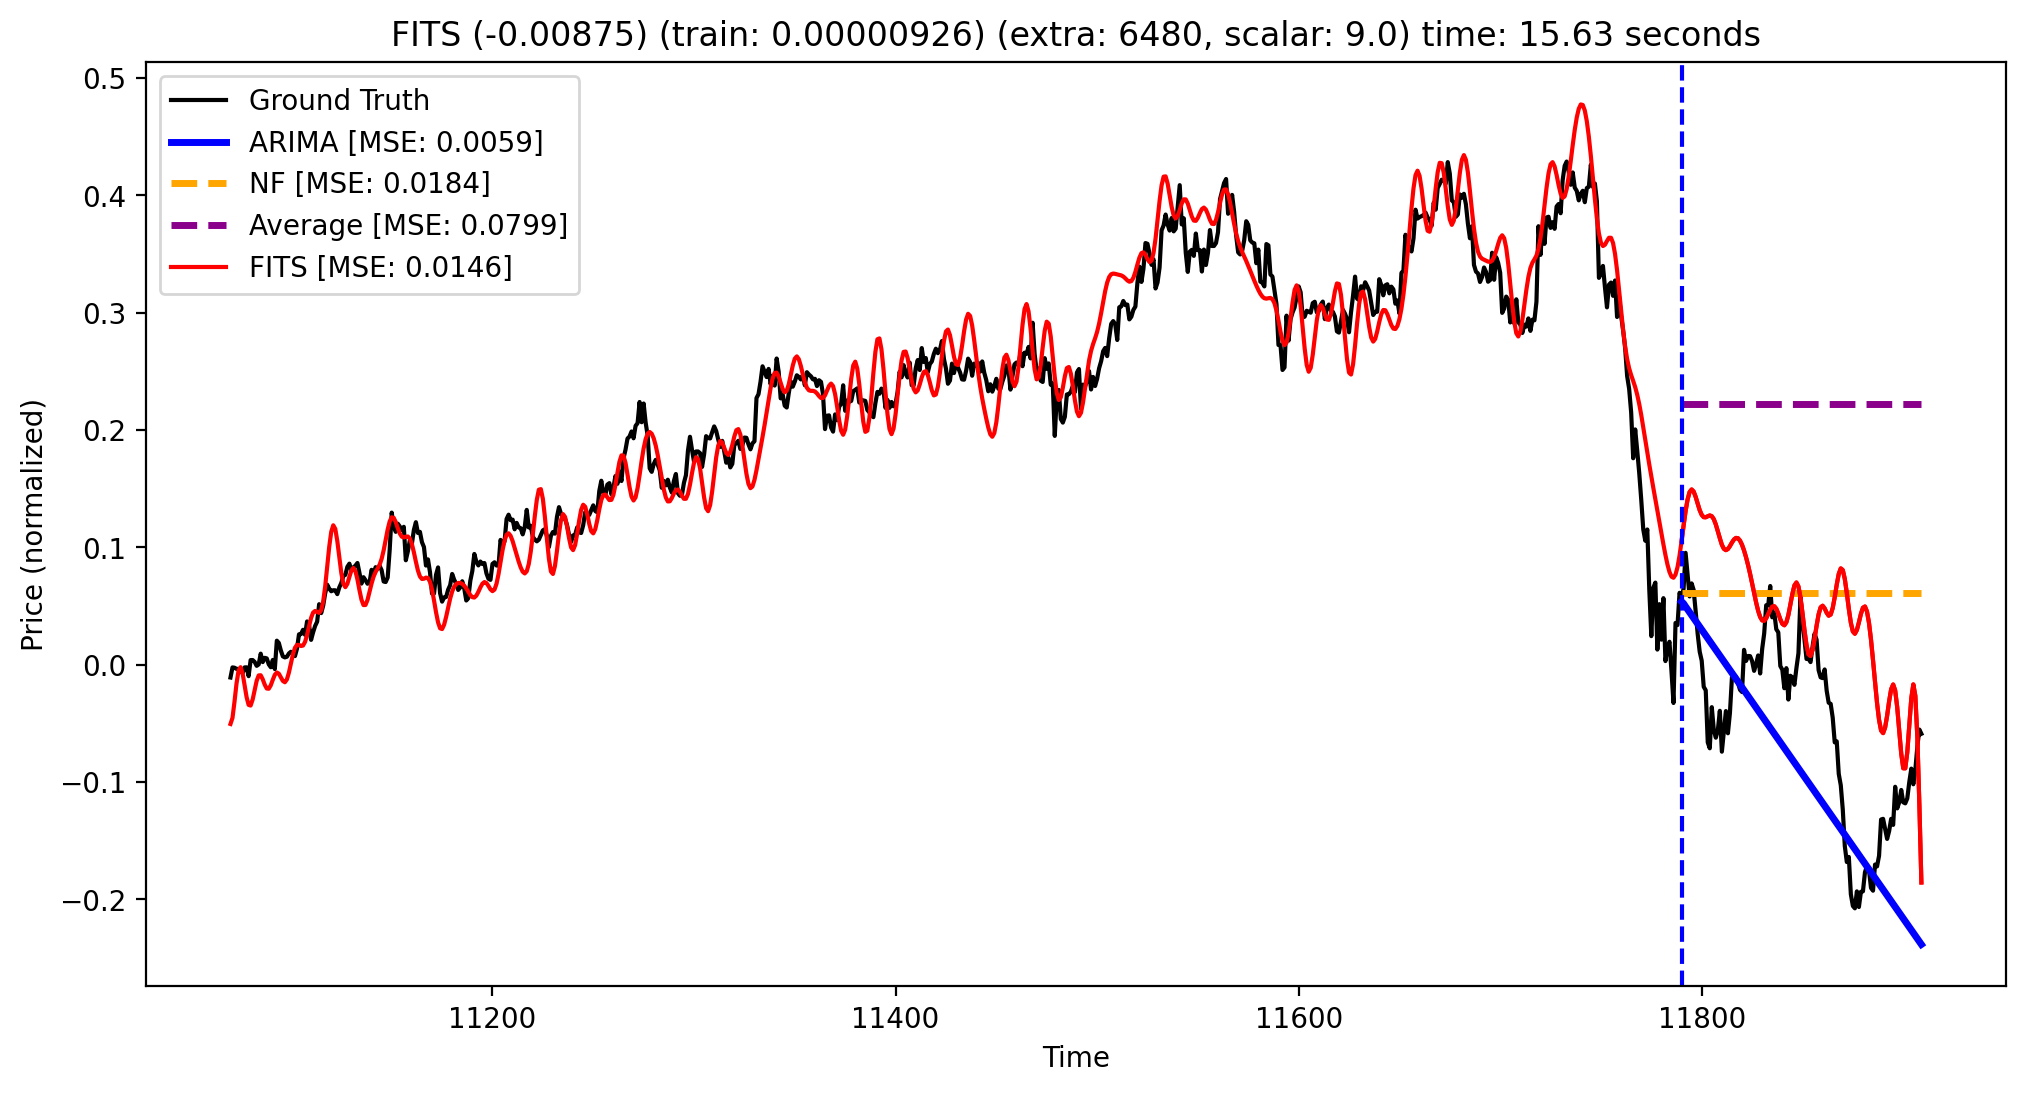

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=1587, bias=True)
)
Parameters 120612
epoch: 299 loss: 0.00000311 val_loss: 0.00032144

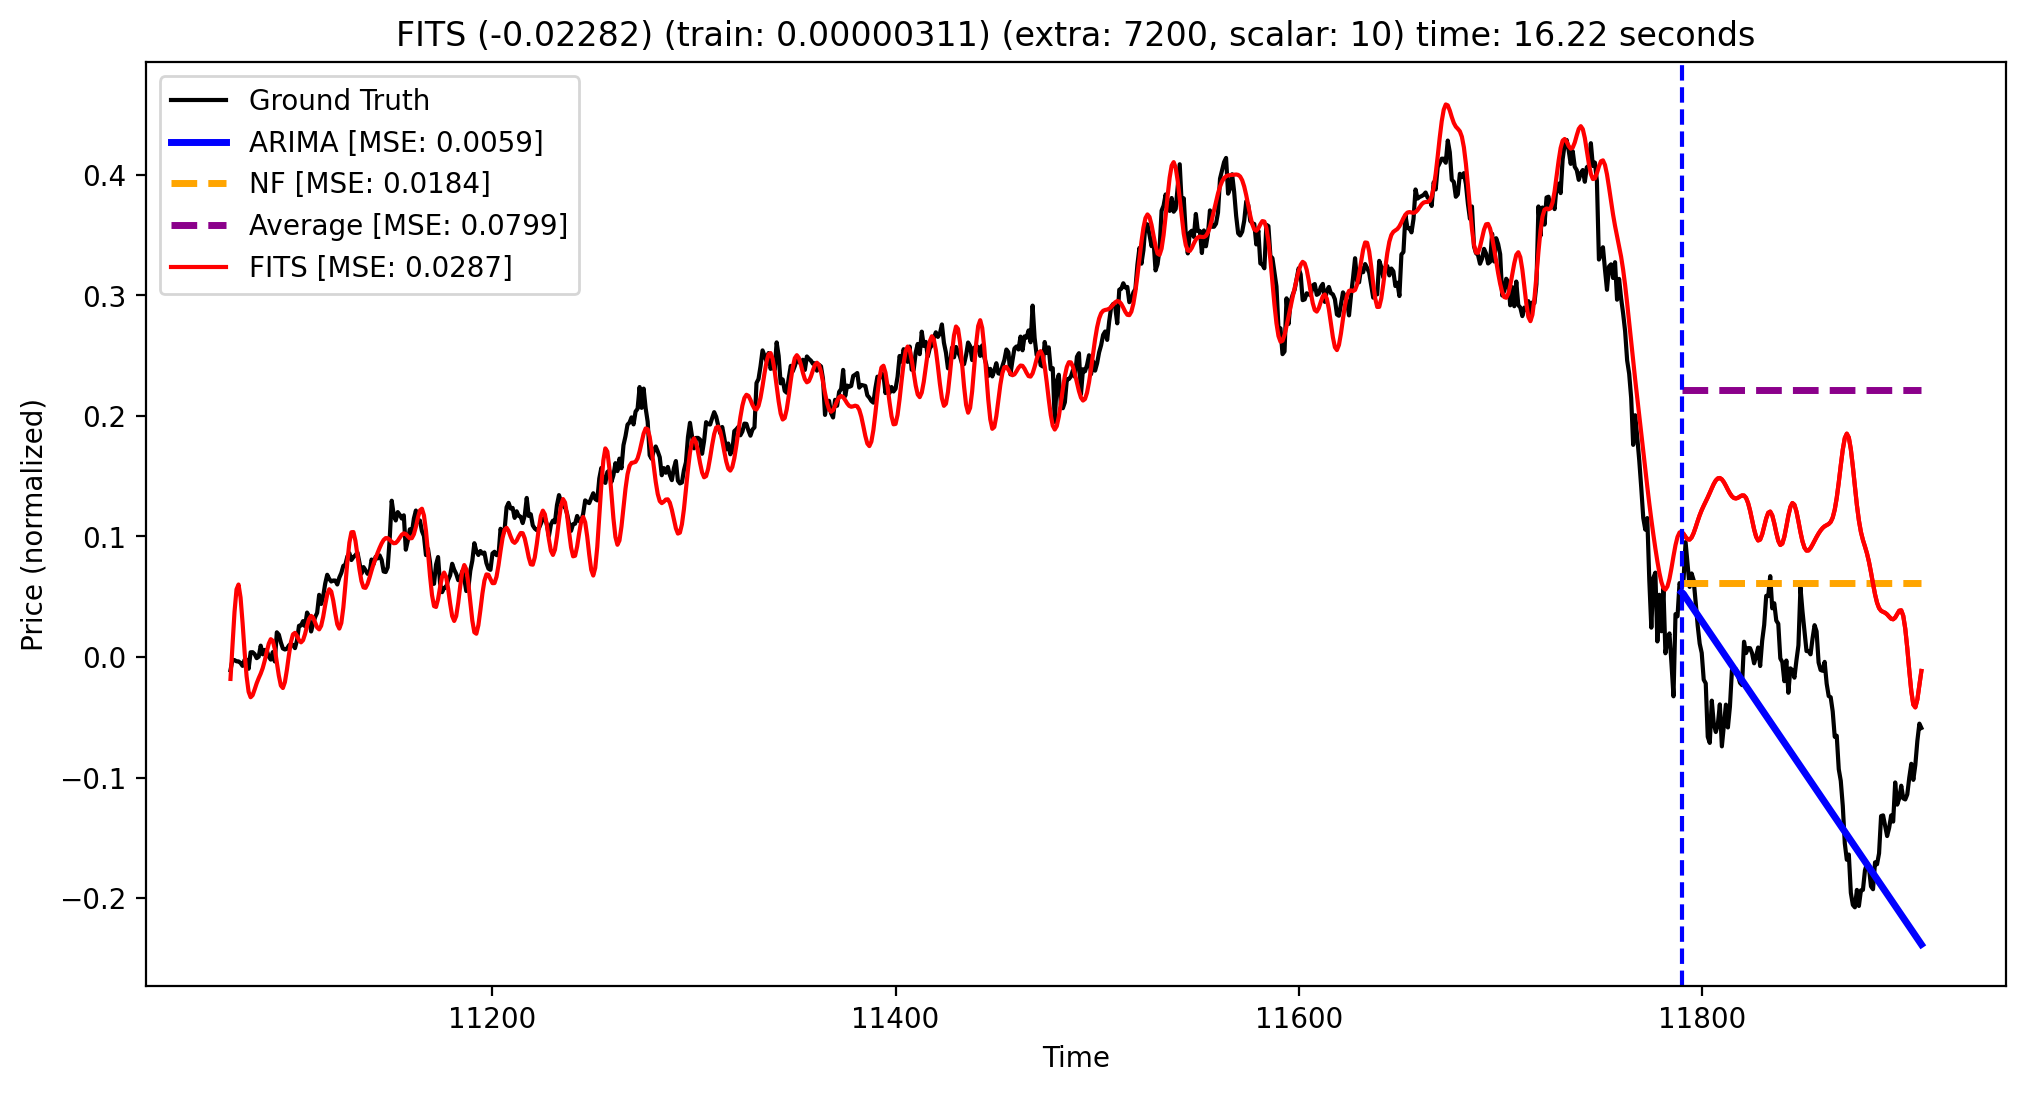

In [12]:
best_scalar_values = [0.002, 0.05, 0.1, 0.2, 1.65, 1.95, 3.05, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10]

for scalar in best_scalar_values:
    plot_this_bitch(scalar)